<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 1. Import Libraries, data preprocessed and scale the data
    

    
</div>

In [199]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

from matplotlib.patches import RegularPolygon
import matplotlib.colors as mpl_colors
import matplotlib.colorbar as colorbar
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl

from math import ceil
from collections import Counter
from sklearn.metrics import pairwise_distances

from sklearn.metrics import silhouette_score, silhouette_samples, calinski_harabasz_score
from scipy.stats import zscore
from sklearn.cluster import KMeans, AgglomerativeClustering,MeanShift, estimate_bandwidth, DBSCAN
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors

from sklearn.manifold import TSNE
from umap import UMAP
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from minisom import MiniSom

#import plotly.express as px
#import plotly.graph_objects as go
#import plotly.colors

#!pip install sompy
#import sompy
## Import sompy components
#from sompy.sompy import SOMFactory
#from sompy.visualization.mapview import MapView
#from sompy.visualization.hitmap import HitMapView

import warnings
warnings.filterwarnings('ignore')
sns.set_style(style="whitegrid")

In [200]:
# import data preprocessed
df_preprocessed = pd.read_csv("data_preprocessed.csv")
df_preprocessed.head(2)

customer_id  customer_region  customer_age  vendor_count  product_count  \
0  1b8f824d5e             2360          18.0             2              5   
1  5d272b9dcb             8670          17.0             2              2   

   is_chain  first_order  last_order last_promo payment_method  ...  \
0         1          0.0           1   DELIVERY           DIGI  ...   
1         2          0.0           1   DISCOUNT           DIGI  ...   

   HR_afternoon  HR_evening  Weekdays  Weekend  total_spent  total_orders  \
0             2         0.0         0        2        28.88             2   
1             0         0.0         0        2        19.21             2   

   avg_spending_per_order  chain_order_ratio  preferred_cui  \
0                  14.440                0.5     CUI_Indian   
1                   9.605                1.0   CUI_American   

   preferred_cui_type  
0       Asian_Cuisine  
1     Western_Cuisine  

[2 rows x 74 columns]

In [201]:
df_preprocessed.drop(columns="customer_id", inplace=True) # it´s easier to have customers id as 0,1,2 for clusters.
df_preprocessed.head(1)

customer_region  customer_age  vendor_count  product_count  is_chain  \
0             2360          18.0             2              5         1   

   first_order  last_order last_promo payment_method  CUI_American  ...  \
0          0.0           1   DELIVERY           DIGI           0.0  ...   

   HR_afternoon  HR_evening  Weekdays  Weekend  total_spent  total_orders  \
0             2         0.0         0        2        28.88             2   

   avg_spending_per_order  chain_order_ratio  preferred_cui  \
0                   14.44                0.5     CUI_Indian   

   preferred_cui_type  
0       Asian_Cuisine  

[1 rows x 73 columns]

Define metric features (same as used in Kmeans)

In [202]:
value_perspetive = ['total_spent', 'avg_spending_per_order', 'last_order']
behaviour_features = ['Weekdays', 'chain_order_ratio', 'HR_breakfast', 'HR_lunch_dinner', 'HR_afternoon', 'HR_evening']
preference_features = ['Western_Cuisine', 'Asian_Cuisine', 'Complementary_Cuisine', 'Other_Cuisines']

In [203]:
metric_features = value_perspetive + behaviour_features + preference_features

In [204]:
# copy of preprocessed to df (scaled one)
df = df_preprocessed.copy()

# List of columns to exclude from scaling
exclude_columns = ["customer_region", "last_promo", "payment_method", "age_category", "chain_frequency", "preferred_cui_type", "preferred_cui"]

# Determine the columns to scale by excluding the specified columns
columns_to_scale = [col for col in df_preprocessed.columns if col not in exclude_columns]

# Instantiate the StandardScaler, fit and transform
ss_scaler = StandardScaler()
ss_scaled_feat = ss_scaler.fit_transform(df[columns_to_scale])

# Update the df with the scaled values
df[columns_to_scale] = ss_scaled_feat

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 2. Functions
    

    
</div>

In [205]:
# set back to white - cleaner
sns.set_style("white")

from matplotlib.colors import LinearSegmentedColormap

# Create a truncated version of the "Blues" colormap - we interact with copilot to determine this for us.
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = LinearSegmentedColormap.from_list(
        'truncated', cmap(np.linspace(minval, maxval, n)))
    return new_cmap

# Use the truncated colormap
blues = plt.get_cmap('Blues')
truncated_blues = truncate_colormap(blues, 0.3, 1.0)  # Adjust minval to exclude the whitest color

In [206]:
# Self-Organizing Maps (SOM)
def plot_component_planes(weights, features, M=3, N=4, figsize=(20, 20), figlayout=(3, 4), title="Component Planes", cmap=cm.magma):
    xx, yy = np.meshgrid(np.arange(N), np.arange(M))
    xx = xx.astype(float)
    yy = yy.astype(float)
    xx[::-2] -= 0.5
    weights_ = np.flipud(np.flip(weights.reshape((M, N, len(features))), axis=1))
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))
    for cpi, sf in zip(range(len(features)), subfigs.flatten()):
        sf.suptitle(features[cpi], y=0.95, fontsize=14)
        axs = sf.subplots(1, 1)
        axs.set_aspect('equal')
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:, :, cpi]), 
                                         vmax=np.max(weights_[:, :, cpi]))
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=.99 / np.sqrt(3),
                                         facecolor=cmap(colornorm(weights_[i, j, cpi])), alpha=1, linewidth=.5,
                                         edgecolor=cmap(colornorm(weights_[i, j, cpi])))
                axs.add_patch(hexagon)
        if int(mpl.__version__.split('.')[1]) >= 6:
            divider = make_axes_locatable(axs)
            ax_cb = divider.append_axes("right", size="7%")
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])
            cb1 = colorbar.Colorbar(ax_cb, orientation='vertical', alpha=1, mappable=cmap_sm)
            sf.add_axes(ax_cb)
        axs.margins(.05)
        axs.axis("off")
    fig.suptitle(title, fontsize=16)
    plt.show()

In [207]:

# Function to plot component planes
def plot_component_planes(weights, features, M=50, N=50, figsize=(12, 7), figlayout=(4, 3), title="Component Planes", cmap=sns.color_palette("RdYlBu", as_cmap=True), title_fontsize=16, legend_fontsize=10):
    xx, yy = np.meshgrid(np.arange(N), np.arange(M))
    xx = xx.astype(float)
    yy = yy.astype(float)
    xx[::-2] -= 0.5
    weights_ = np.flipud(np.flip(weights.reshape((M, N, len(features))), axis=1))
    fig = plt.figure(figsize=figsize, constrained_layout=True)
    subfigs = fig.subfigures(figlayout[0], figlayout[1], wspace=.15)
    colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))
    for cpi, sf in zip(range(len(features)), subfigs.flatten()):
        sf.suptitle(features[cpi], y=0.95, fontsize=legend_fontsize)
        axs = sf.subplots(1, 1)
        axs.set_aspect('equal')
        colornorm = mpl_colors.Normalize(vmin=np.min(weights_[:, :, cpi]), 
                                         vmax=np.max(weights_[:, :, cpi]))
        for i in range(weights_.shape[0]):
            for j in range(weights_.shape[1]):
                wy = yy[(i, j)] * np.sqrt(3) / 2
                hexagon = RegularPolygon((xx[(i, j)], wy), numVertices=6, radius=.99 / np.sqrt(3),
                                         facecolor=cmap(colornorm(weights_[i, j, cpi])), alpha=1, linewidth=.5,
                                         edgecolor=cmap(colornorm(weights_[i, j, cpi])))
                axs.add_patch(hexagon)
        if int(mpl.__version__.split('.')[1]) >= 6:
            divider = make_axes_locatable(axs)
            ax_cb = divider.append_axes("right", size="7%")
            cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
            cmap_sm.set_array([])
            cb1 = colorbar.Colorbar(ax_cb, orientation='vertical', alpha=1, mappable=cmap_sm)
            sf.add_axes(ax_cb)
        axs.margins(.05)
        axs.axis("off")
    fig.suptitle(title, fontsize=title_fontsize)
    plt.show()

In [208]:

# Calculate R2 and see the score
def get_sst(df): 
    """
    Calculates the sum of squared distances of each point to the mean of the points
    """
    return np.sum(df.var() * (df.count() - 1))

def get_r2_score(df, labels):
    """
    Calculates the proportion of variance explained by the clustering (r2)
    """
    sst = get_sst(df)
    ssw = np.sum(df.groupby(labels).apply(get_sst))
    ssb = sst - ssw
    return ssb / sst

# Hierarchical Clustering
def get_r2_hc(df, link_method, max_nclus, min_nclus=1, metric="euclidean"):
    sst = get_sst(df)
    
    r2 = []  
    for i in range(min_nclus, max_nclus+1):
        cluster = AgglomerativeClustering(n_clusters=i, metric=metric, linkage=link_method)
        hclabels = cluster.fit_predict(df) 
        df_concat = df.copy()
        df_concat['labels'] = hclabels
        r2.append(get_r2_score(df_concat, 'labels'))
        
    return np.array(r2)

In [209]:
def hierarchical_clustering_methods_nclust_analysis(dataframe, hc_methods, max_nclus, metric="euclidean"):
    r2_hc_methods = np.vstack(
        [
            get_r2_hc(dataframe, link, max_nclus, metric=metric)
            for link in hc_methods
        ]
    ).T

    r2_hc_methods = pd.DataFrame(r2_hc_methods, index=range(1, max_nclus + 1), columns=hc_methods)

    sns.set()
    fig = plt.figure(figsize=(11, 5))
    sns.lineplot(data=r2_hc_methods, linewidth=2.5, markers=["o"]*4)
    fig.suptitle("R2 plot for various hierarchical methods", fontsize=21)
    plt.legend(title="HC methods", title_fontsize=11)
    plt.xticks(range(1, max_nclus + 1))
    plt.xlabel("Number of clusters", fontsize=13)
    plt.ylabel("R2 metric", fontsize=13)
    plt.show()


In [210]:
def plot_dendrogram(dataframe, y_threshold, linkage="ward", metric='euclidean'):
    hclust = AgglomerativeClustering(linkage=linkage, metric=metric, distance_threshold=0, n_clusters=None)
    hclust.fit(dataframe)

    counts = np.zeros(hclust.children_.shape[0])
    n_samples = len(hclust.labels_)

    for i, merge in enumerate(hclust.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count
    
    linkage_matrix = np.column_stack(
        [hclust.children_, hclust.distances_, counts]
    ).astype(float)

    sns.set()
    fig = plt.figure(figsize=(11, 5))
    dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=y_threshold, above_threshold_color='k')
    plt.hlines(y_threshold, 0, plt.gca().get_xlim()[1], colors="r", linestyles="dashed")
    plt.title(f'Hierarchical Clustering - {linkage} | Dendrogram', fontsize=21)
    plt.xlabel('Number of points in node (or index of point if no parenthesis)')
    plt.ylabel(f'{metric} Distance', fontsize=13)
    plt.show()

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 3. Minisom
    

    
</div>

<a class="anchor" id="3rd-bullet">

### MiniSom Value Perspetive
    
</a>

In [211]:
df_value = df[value_perspetive].copy()

In [212]:
from minisom import MiniSom

M = 20
N = 30
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(value_perspetive)
learning_rate = .7

som_data = df_value.values

sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 

print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
#print("TE", np.round(sm.topographic_error(som_data),4))

# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
#print("TE", np.round(sm.topographic_error(som_data),4))

Before training:
QE 0.179
After training:
QE 0.1862


In [213]:
weights = sm.get_weights()
weights.shape

(20, 30, 3)

In [214]:
def plot_hexagons(som,              # Trained SOM model 
                  sf,               # matplotlib figure object
                  colornorm,        # colornorm
                  matrix_vals,      # SOM weights or
                  label="",         # title for figure
                  cmap=cm.Grays,    # colormap to use
                  annot=False       
                  ):

    
    axs = sf.subplots(1,1)
    
    for i in range(matrix_vals.shape[0]):
        for j in range(matrix_vals.shape[1]):

            wx, wy = som.convert_map_to_euclidean((i,j)) 

            hex = RegularPolygon((wx, wy), 
                                numVertices=6, 
                                radius= np.sqrt(1/3),
                                facecolor=cmap(colornorm(matrix_vals[i, j])), 
                                alpha=1, 
                                edgecolor='white',
                                linewidth=.5)
            axs.add_patch(hex)
            if annot==True:
                annot_val = np.round(matrix_vals[i,j],2)
                if int(annot_val) == annot_val:
                    annot_val = int(annot_val)
                axs.text(wx,wy, annot_val, 
                        ha='center', va='center', 
                        fontsize='x-small')


    ## Remove axes for hex plot
    axs.margins(.05)
    axs.set_aspect('equal')
    axs.axis("off")
    axs.set_title(label) 

    # ## Add colorbar
    divider = make_axes_locatable(axs)
    ax_cb = divider.append_axes("right", size="5%", pad="0%")

    ## Create a Mappable object
    cmap_sm = plt.cm.ScalarMappable(cmap=cmap, norm=colornorm)
    cmap_sm.set_array([])

    ## Create custom colorbar 
    cb1 = colorbar.Colorbar(ax_cb,
                            orientation='vertical', 
                            alpha=1,
                            mappable=cmap_sm
                            )
    cb1.ax.get_yaxis().labelpad = 6

    # Add colorbar to plot
    sf.add_axes(ax_cb)

    return sf 

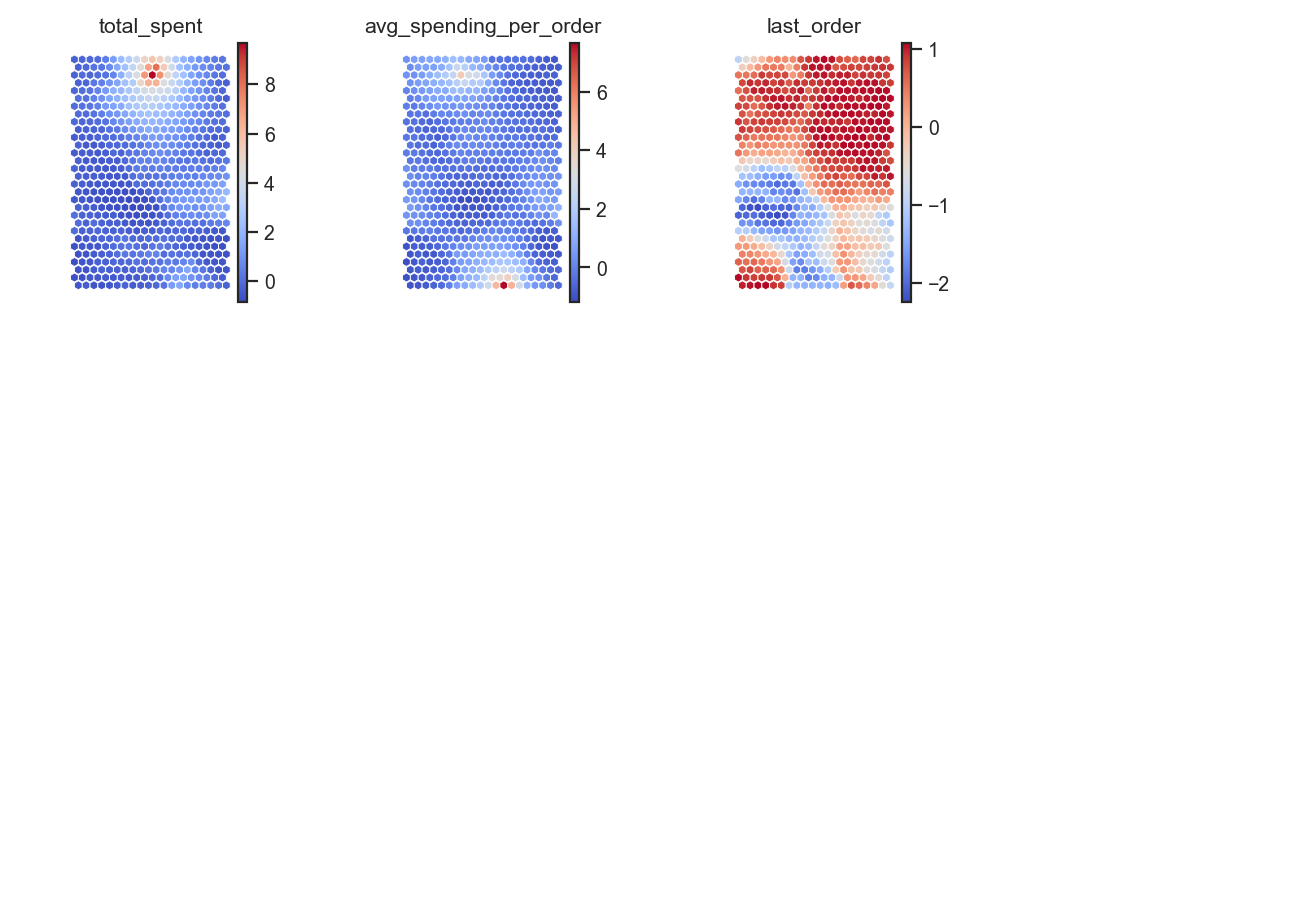

In [215]:
##############################
# Plot Component Planes
##############################

figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(3,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(value_perspetive)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=value_perspetive[cpi],
                    cmap=cm.coolwarm,
                    )

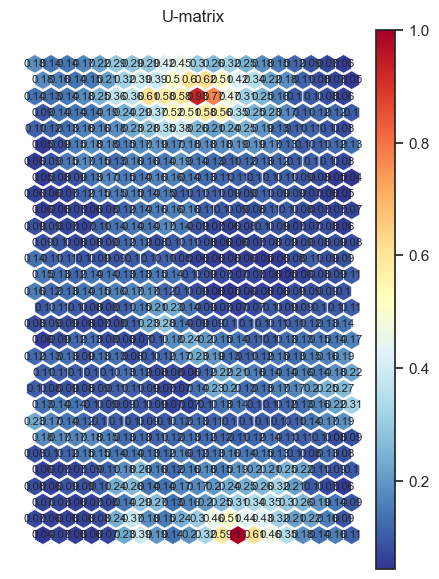

In [216]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

In [217]:
## Flip and rotate to match plot
print(np.flip(np.round(umatrix,2), axis=1).T)

[[0.18 0.14 0.14 0.17 0.22 0.29 0.29 0.29 0.42 0.45 0.3  0.26 0.32 0.25
  0.18 0.15 0.12 0.09 0.07 0.06]
 [0.18 0.16 0.14 0.15 0.21 0.32 0.39 0.39 0.5  0.6  0.62 0.51 0.42 0.34
  0.22 0.18 0.11 0.08 0.07 0.05]
 [0.14 0.13 0.14 0.18 0.25 0.36 0.36 0.61 0.58 0.58 0.93 0.77 0.47 0.31
  0.25 0.16 0.1  0.1  0.08 0.06]
 [0.09 0.14 0.14 0.14 0.19 0.24 0.29 0.37 0.52 0.51 0.58 0.56 0.35 0.25
  0.23 0.17 0.11 0.12 0.12 0.1 ]
 [0.11 0.12 0.13 0.16 0.16 0.18 0.23 0.28 0.35 0.38 0.26 0.21 0.24 0.25
  0.19 0.13 0.11 0.11 0.1  0.08]
 [0.05 0.09 0.15 0.18 0.18 0.15 0.17 0.19 0.17 0.18 0.18 0.18 0.19 0.19
  0.17 0.13 0.1  0.11 0.12 0.13]
 [0.06 0.09 0.15 0.17 0.15 0.13 0.16 0.16 0.14 0.19 0.14 0.13 0.11 0.12
  0.13 0.12 0.1  0.1  0.1  0.08]
 [0.05 0.08 0.09 0.13 0.17 0.15 0.14 0.16 0.16 0.14 0.13 0.11 0.11 0.1
  0.1  0.11 0.09 0.08 0.05 0.04]
 [0.06 0.06 0.07 0.12 0.15 0.15 0.15 0.14 0.15 0.11 0.11 0.11 0.09 0.09
  0.11 0.09 0.09 0.07 0.06 0.05]
 [0.06 0.06 0.07 0.06 0.08 0.12 0.14 0.16 0.16 0.16 0.11

In [218]:
sm.quantization_error(df[value_perspetive].values)

0.18620277681466751

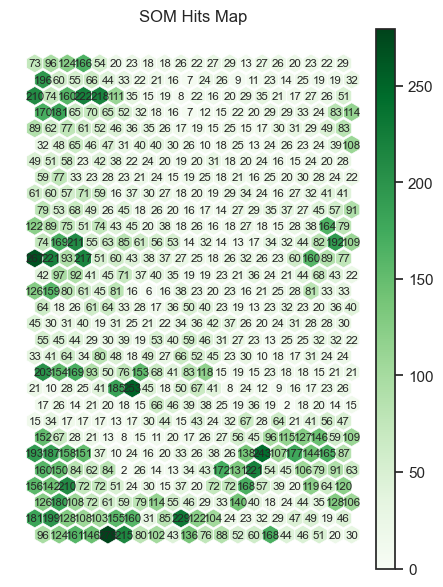

In [219]:
hitsmatrix = sm.activation_response(df_value.values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )

In [220]:
np.flip(np.round(hitsmatrix,2), axis=1).T

array([[ 73.,  96., 124., 166.,  54.,  20.,  23.,  18.,  18.,  26.,  22.,
         27.,  29.,  13.,  27.,  26.,  20.,  23.,  22.,  29.],
       [196.,  60.,  55.,  66.,  44.,  33.,  22.,  21.,  16.,   7.,  24.,
         26.,   9.,  11.,  23.,  14.,  25.,  19.,  19.,  32.],
       [210.,  74., 160., 222., 218., 111.,  35.,  15.,  19.,   8.,  22.,
         16.,  20.,  29.,  35.,  21.,  17.,  27.,  26.,  51.],
       [170., 181.,  65.,  70.,  65.,  52.,  32.,  18.,  16.,   7.,  12.,
         15.,  22.,  20.,  29.,  29.,  33.,  24.,  83., 114.],
       [ 89.,  62.,  77.,  61.,  52.,  46.,  36.,  35.,  26.,  17.,  19.,
         15.,  25.,  15.,  17.,  30.,  31.,  29.,  49.,  83.],
       [ 32.,  48.,  65.,  46.,  47.,  31.,  40.,  40.,  30.,  26.,  10.,
         18.,  25.,  13.,  24.,  26.,  23.,  24.,  39., 108.],
       [ 49.,  51.,  58.,  23.,  42.,  38.,  22.,  24.,  20.,  19.,  20.,
         31.,  18.,  20.,  24.,  16.,  15.,  24.,  20.,  28.],
       [ 59.,  77.,  33.,  23.,  28.,  23

In [221]:
weights_flat = sm.get_weights().reshape((M*N),len(value_perspetive))
weights_flat.shape

(600, 3)

In [222]:
# Perform K-Means clustering on top of the MxN units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
nodeclus_labels = kmeans.fit_predict(weights_flat)
nodeclus_labels

array([1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 3, 3, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 3, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 3, 1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 0, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2,
       2, 2, 2, 2, 2, 2, 0, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 0,

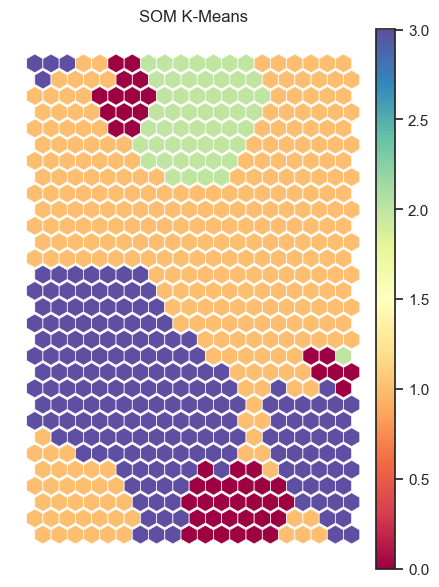

In [223]:
kmeans_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

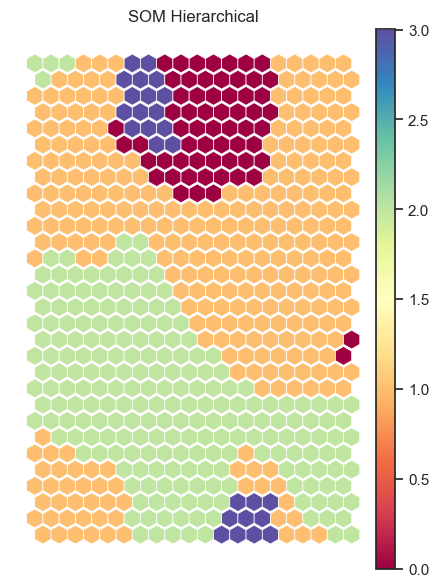

In [224]:
# Perform Hierarchical clustering on top of the MxN units 

hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(weights_flat)
hclust_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hclust_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hclust_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )

In [225]:
# Check the nodes and and respective clusters
nodes = weights_flat

df_nodes = pd.DataFrame(nodes, columns=value_perspetive)
df_nodes['value_label'] = nodeclus_labels
df_nodes

total_spent  avg_spending_per_order  last_order  value_label
0      -0.562643               -0.979174    0.992266            1
1      -0.699483               -1.039028    1.065068            1
2      -0.597485               -0.948842    0.732818            1
3      -0.724189               -1.102738    0.656420            1
4      -0.710882               -0.975083    0.440086            1
..           ...                     ...         ...          ...
595    -0.139916               -0.906130    1.049073            1
596    -0.320150               -0.793197    0.868335            1
597     0.004134               -0.744635    0.844494            1
598     0.087393               -0.855026    0.897368            1
599     0.174284               -0.916139    0.774232            1

[600 rows x 4 columns]

In [226]:
## This gets BMU coordinates, e.g. (4,4) for each data point
bmu_index = np.array([sm.winner(x) for x in df_value.values])

print(bmu_index.shape)

bmu_index

(31717, 2)


array([[ 1, 10],
       [ 2, 10],
       [ 6,  9],
       ...,
       [ 0, 10],
       [ 2, 10],
       [ 5,  9]], dtype=int64)

In [227]:

## This gets the cluster label from hclust_matrix, i.e.
## if data row 0 has BMU at (37, 28) 
## it will get the label associated to node (37,28) using label associated to hclust_matrix[37,28] above

som_final_labels = [hclust_matrix[i[0]][i[1]] for i in bmu_index]

In [228]:
df = pd.concat([
                df,
                pd.Series(som_final_labels, name='value_label', index=df.index)
            ], axis=1
            )

df

customer_region  customer_age  vendor_count  product_count  is_chain  \
0                 2360     -1.337468     -0.405436      -0.098281 -0.475544   
1                 8670     -1.478630     -0.405436      -0.555346 -0.212185   
2                 4660      1.485773     -0.771607      -0.555346 -0.212185   
3                 4660     -0.208171     -0.405436      -0.402991 -0.475544   
4                 4660     -1.055144     -0.405436      -0.098281 -0.738902   
...                ...           ...           ...            ...       ...   
31712             8670      0.356477     -0.771607      -0.707701 -0.475544   
31713             8670     -0.208171     -0.771607      -0.707701 -0.738902   
31714             8670     -0.490496     -0.771607      -0.707701 -0.475544   
31715             8670      0.921125     -0.771607      -0.707701 -0.738902   
31716             4660      0.356477     -0.771607      -0.707701 -0.738902   

       first_order  last_order last_promo payment_method  CUI_American  ...  \
0        -1.175717   -2.706721   DELIVERY           DIGI     -0.422050  ...   
1        -1.175717   -2.706721   DISCOUNT           DIGI      0.686724  ...   
2        -1.175717   -2.706721   DISCOUNT           CASH      0.373638  ...   
3        -1.175717   -2.663582   DELIVERY           DIGI     -0.422050  ...   
4        -1.175717   -2.663582          -           DIGI      0.838078  ...   
...            ...         ...        ...            ...           ...  ...   
31712    -1.175717   -2.749860    FREEBIE           DIGI     -0.422050  ...   
31713    -1.175717   -2.749860   DELIVERY           DIGI      1.138191  ...   
31714    -1.175717   -2.749860          -           DIGI     -0.422050  ...   
31715    -1.175717   -2.749860   DISCOUNT           DIGI     -0.422050  ...   
31716    -1.175717   -2.749860          -           CASH     -0.422050  ...   

       HR_evening  Weekdays   Weekend  total_spent  total_orders  \
0       -0.392136 -0.857128  0.429816    -0.209739      -0.48370   
1       -0.392136 -0.857128  0.429816    -0.427887      -0.48370   
2       -0.392136 -0.857128  0.429816    -0.653705      -0.48370   
3       -0.392136 -0.580495 -0.148714    -0.149281      -0.48370   
4       -0.392136 -0.580495 -0.148714     0.389434      -0.48370   
...           ...       ...       ...          ...           ...   
31712   -0.392136 -0.857128 -0.148714    -0.454282      -0.68905   
31713   -0.392136 -0.857128 -0.148714    -0.454282      -0.68905   
31714    0.373005 -0.857128 -0.148714    -0.459921      -0.68905   
31715   -0.392136 -0.857128 -0.148714    -0.589863      -0.68905   
31716   -0.392136 -0.857128 -0.148714    -0.682807      -0.68905   

       avg_spending_per_order  chain_order_ratio  preferred_cui  \
0                    0.528655          -0.327866     CUI_Indian   
1                   -0.088755           0.963778   CUI_American   
2                   -0.727873           0.963778   CUI_American   
3                    0.699767          -0.327866     CUI_Indian   
4                    2.224456          -1.619510      CUI_Asian   
...                       ...                ...            ...   
31712                0.988360           0.963778  CUI_Beverages   
31713                0.988360          -1.619510   CUI_American   
31714                0.956436           0.963778   CUI_Desserts   
31715                0.220908          -1.619510      CUI_Asian   
31716               -0.305200          -1.619510    CUI_Italian   

          preferred_cui_type  value_label  
0              Asian_Cuisine            2  
1            Western_Cuisine            2  
2            Western_Cuisine            2  
3              Asian_Cuisine            2  
4              Asian_Cuisine            2  
...                      ...          ...  
31712  Complementary_Cuisine            2  
31713        Western_Cuisine            2  
31714  Complementary_Cuisine            2  
31715          Asian_Cuisine            2  
317

In [229]:
# Characterizing the final clusters
df_centroids = df[value_perspetive + ['value_label']].groupby('value_label').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled



In [230]:
df["value_label"].value_counts()

value_label
1    16833
2    12521
0     1263
3     1100
Name: count, dtype: int64

In [231]:
# Calculate R2 and see the score
def get_sst(df): 
    """
    Calculates the sum of squared distances of each point to the mean of the points
    """
    return np.sum(df.var() * (df.count() - 1))

def get_r2_score(df, labels):
    """
    Calculates the proportion of variance explained by the clustering (r2)
    """
    sst = get_sst(df)
    ssw = np.sum(df.groupby(labels).apply(get_sst))
    ssb = sst - ssw
    return ssb / sst

In [232]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_value)  # get total sum of squares
ssw_labels = df[value_perspetive + ["value_label"]].groupby(by='value_label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.523525862331195

In [233]:
calinski_harabasz = calinski_harabasz_score(df_value, som_final_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  11614.884


In [234]:
# This is step can be quite time consuming so it´s in ##
#two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df[value_perspetive])

# t-SNE visualization
#pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['value_label'], colormap='tab10', figsize=(15,10))
#plt.show()

<a class="anchor" id="3rd-bullet">

### MiniSom Preferences
    
</a>

In [235]:
df_prf = df[preference_features].copy()

In [236]:
from minisom import MiniSom

M = 20
N = 30
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(preference_features)
learning_rate = .7

som_data = df_prf.values

sm = MiniSom(M, N,              # 10x10 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 

print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
#print("TE", np.round(sm.topographic_error(som_data),4))

# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
#print("TE", np.round(sm.topographic_error(som_data),4))

Before training:
QE 0.2334
After training:
QE 0.1706


In [237]:
weights = sm.get_weights()
weights.shape

(20, 30, 4)

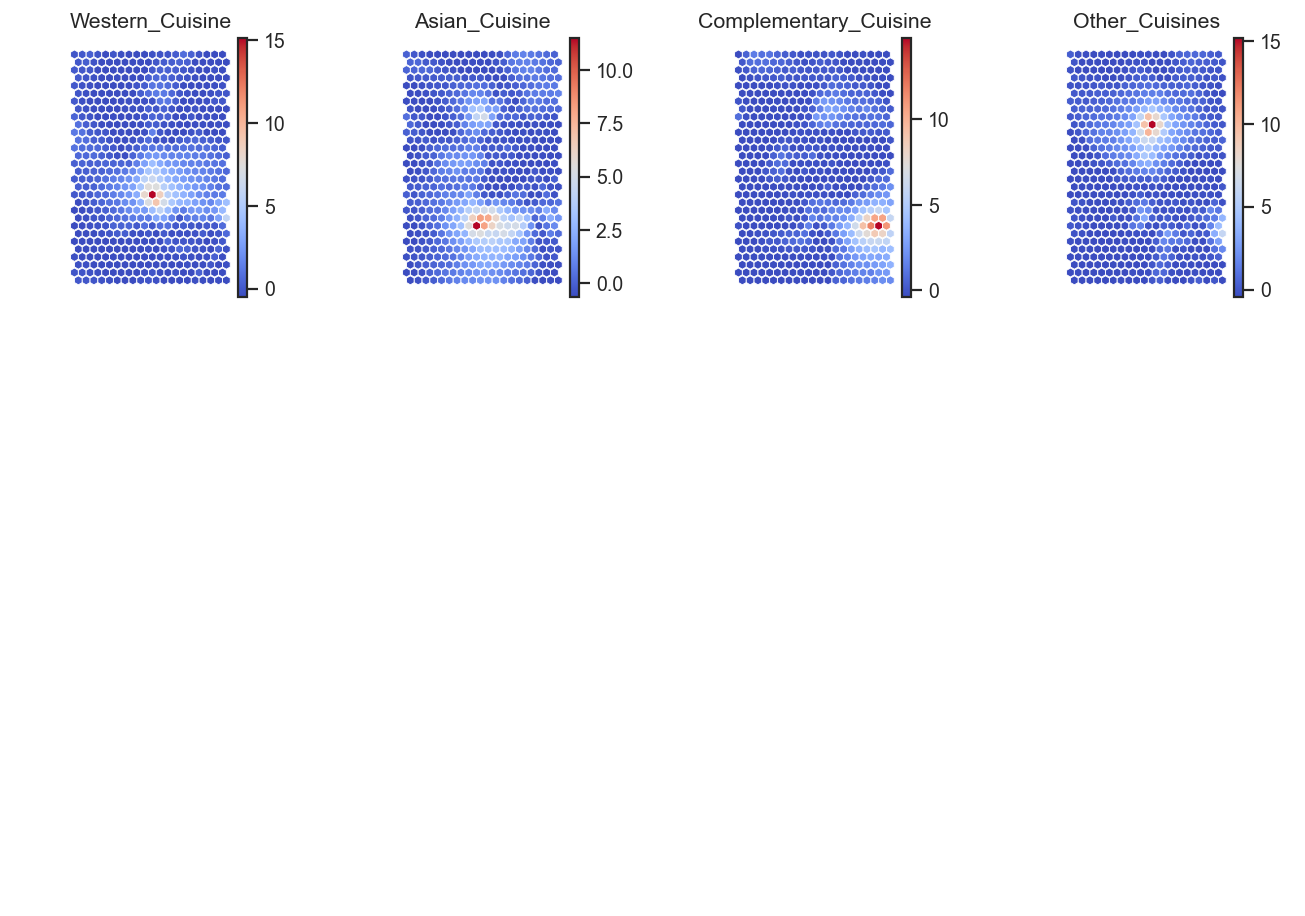

In [238]:
##############################
# Plot Component Planes
##############################

figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(3,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(preference_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=preference_features[cpi],
                    cmap=cm.coolwarm,
                    )

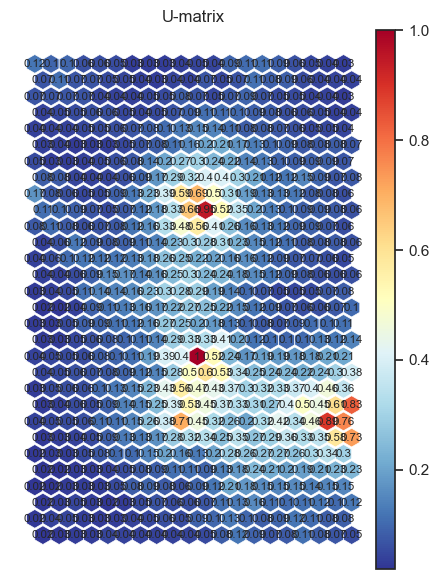

In [239]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

In [240]:
## Flip and rotate to match plot
print(np.flip(np.round(umatrix,2), axis=1).T)

[[0.12 0.1  0.1  0.06 0.06 0.05 0.03 0.03 0.03 0.04 0.05 0.04 0.09 0.11
  0.11 0.09 0.06 0.05 0.04 0.03]
 [0.07 0.11 0.07 0.07 0.05 0.05 0.04 0.03 0.04 0.04 0.07 0.05 0.07 0.11
  0.08 0.09 0.06 0.04 0.04 0.04]
 [0.07 0.07 0.07 0.07 0.04 0.04 0.04 0.05 0.05 0.08 0.07 0.05 0.07 0.09
  0.07 0.05 0.05 0.04 0.04 0.03]
 [0.04 0.05 0.05 0.06 0.06 0.05 0.04 0.05 0.07 0.09 0.11 0.11 0.1  0.09
  0.08 0.06 0.06 0.05 0.04 0.04]
 [0.04 0.04 0.04 0.05 0.05 0.06 0.07 0.08 0.1  0.13 0.15 0.14 0.11 0.08
  0.08 0.07 0.06 0.05 0.05 0.04]
 [0.03 0.04 0.03 0.03 0.03 0.05 0.07 0.08 0.11 0.16 0.2  0.21 0.17 0.13
  0.1  0.09 0.08 0.08 0.08 0.07]
 [0.05 0.03 0.03 0.04 0.05 0.06 0.08 0.14 0.2  0.27 0.3  0.24 0.22 0.14
  0.13 0.1  0.09 0.09 0.09 0.07]
 [0.08 0.08 0.04 0.04 0.04 0.06 0.09 0.17 0.29 0.32 0.4  0.4  0.3  0.21
  0.12 0.12 0.15 0.09 0.07 0.08]
 [0.17 0.08 0.06 0.05 0.05 0.09 0.13 0.23 0.39 0.59 0.69 0.5  0.31 0.19
  0.13 0.13 0.12 0.08 0.08 0.06]
 [0.11 0.1  0.09 0.07 0.05 0.07 0.12 0.18 0.33 0.66 0.9

In [241]:
sm.quantization_error(df_prf.values)

0.1706490910210768

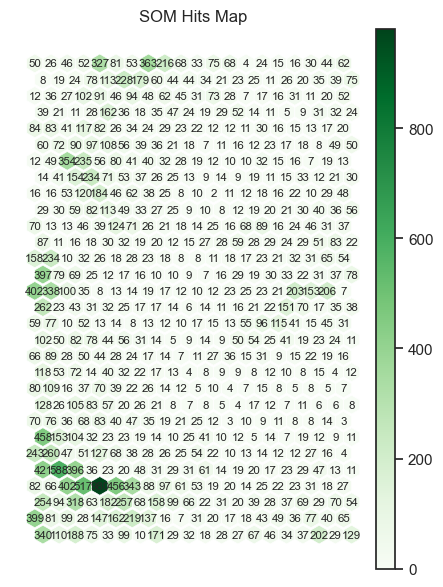

In [242]:
hitsmatrix = sm.activation_response(df_prf.values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )

In [243]:
np.flip(np.round(hitsmatrix,2), axis=1).T

array([[ 50.,  26.,  46.,  52., 327.,  81.,  53., 363., 216.,  68.,  33.,
         75.,  68.,   4.,  24.,  15.,  16.,  30.,  44.,  62.],
       [  8.,  19.,  24.,  78., 113., 228., 179.,  60.,  44.,  44.,  34.,
         21.,  23.,  25.,  11.,  26.,  20.,  35.,  39.,  75.],
       [ 12.,  36.,  27., 102.,  91.,  46.,  94.,  48.,  62.,  45.,  31.,
         73.,  28.,   7.,  17.,  16.,  31.,  11.,  20.,  52.],
       [ 39.,  21.,  11.,  28., 162.,  36.,  18.,  35.,  47.,  24.,  19.,
         29.,  52.,  14.,  11.,   5.,   9.,  31.,  32.,  24.],
       [ 84.,  83.,  41., 117.,  82.,  26.,  34.,  24.,  29.,  23.,  22.,
         12.,  12.,  11.,  30.,  16.,  15.,  13.,  17.,  20.],
       [ 60.,  72.,  90.,  97., 108.,  56.,  39.,  36.,  21.,  18.,   7.,
         11.,  16.,  12.,  23.,  17.,  18.,   8.,  49.,  50.],
       [ 12.,  49., 354., 235.,  56.,  80.,  41.,  40.,  32.,  28.,  19.,
         12.,  10.,  10.,  32.,  15.,  16.,   7.,  19.,  13.],
       [ 14.,  41., 154., 234.,  71.,  53

In [244]:
weights_flat = sm.get_weights().reshape((M*N),len(preference_features))
weights_flat.shape

(600, 4)

In [245]:
# Perform K-Means clustering on top of the MxN units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
nodeclus_labels = kmeans.fit_predict(weights_flat)
nodeclus_labels

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 3, 3, 3, 3, 3, 3, 3, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 3, 0, 0, 0, 0, 0, 0, 0,
       3, 3, 3, 3, 3, 3, 3, 1, 1, 1, 1, 1, 1, 1, 1,

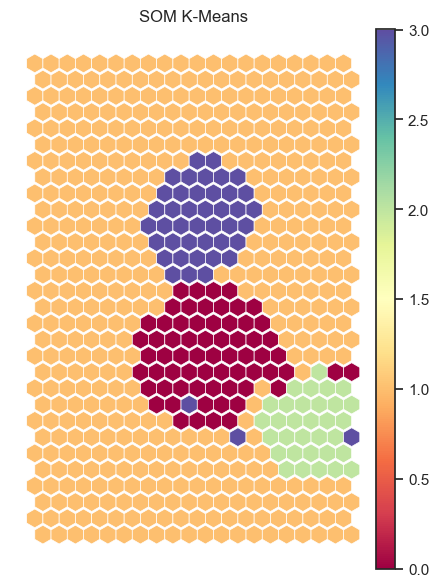

In [246]:
kmeans_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

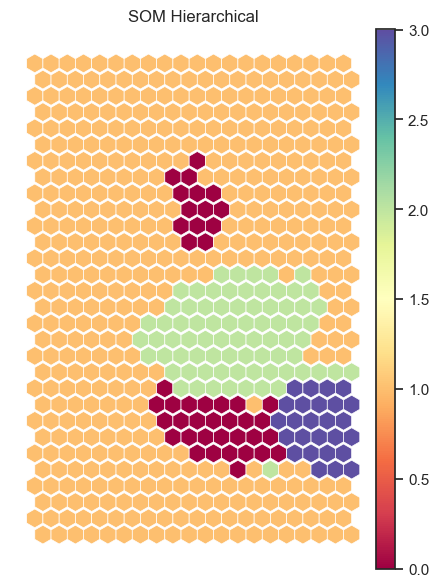

In [247]:
# Perform Hierarchical clustering on top of the MxN units 

hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(weights_flat)
hclust_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hclust_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hclust_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )

In [248]:
# Check the nodes and and respective clusters
nodes = weights_flat

df_nodes = pd.DataFrame(nodes, columns=preference_features)
df_nodes['label'] = nodeclus_labels
df_nodes

Western_Cuisine  Asian_Cuisine  Complementary_Cuisine  Other_Cuisines  \
0          -0.043719      -0.622738              -0.366332       -0.423262   
1          -0.168087      -0.622686              -0.366415       -0.423569   
2          -0.306739      -0.619138              -0.357074       -0.409478   
3          -0.325879      -0.514969              -0.363022       -0.415693   
4          -0.482650      -0.466322              -0.366326       -0.424429   
..               ...            ...                    ...             ...   
595        -0.285023       0.672958              -0.363301       -0.353216   
596        -0.447521       0.326944              -0.362111       -0.206640   
597        -0.481038       0.249603              -0.365644       -0.068233   
598        -0.465084       0.000849              -0.364333       -0.086647   
599        -0.476047      -0.033762              -0.366311        0.087632   

     label  
0        1  
1        1  
2        1  
3        1  
4        1  
..     ...  
595      1  
596      1  
597      1  
598      1  
599      1  

[600 rows x 5 columns]

In [249]:
## This gets BMU coordinates, e.g. (4,4) for each data point
bmu_index = np.array([sm.winner(x) for x in df_prf.values])

print(bmu_index.shape)

bmu_index

(31717, 2)


array([[ 6,  3],
       [ 2, 15],
       [ 0, 14],
       ...,
       [ 4, 29],
       [ 3,  3],
       [ 0,  0]], dtype=int64)

In [250]:

## This gets the cluster label from hclust_matrix, i.e.
## if data row 0 has BMU at (37, 28) 
## it will get the label associated to node (37,28) using label associated to hclust_matrix[37,28] above

som_final_labels = [hclust_matrix[i[0]][i[1]] for i in bmu_index]

In [251]:
df = pd.concat([
                df,
                pd.Series(som_final_labels, name='prf_label', index=df.index)
            ], axis=1
            )

df

customer_region  customer_age  vendor_count  product_count  is_chain  \
0                 2360     -1.337468     -0.405436      -0.098281 -0.475544   
1                 8670     -1.478630     -0.405436      -0.555346 -0.212185   
2                 4660      1.485773     -0.771607      -0.555346 -0.212185   
3                 4660     -0.208171     -0.405436      -0.402991 -0.475544   
4                 4660     -1.055144     -0.405436      -0.098281 -0.738902   
...                ...           ...           ...            ...       ...   
31712             8670      0.356477     -0.771607      -0.707701 -0.475544   
31713             8670     -0.208171     -0.771607      -0.707701 -0.738902   
31714             8670     -0.490496     -0.771607      -0.707701 -0.475544   
31715             8670      0.921125     -0.771607      -0.707701 -0.738902   
31716             4660      0.356477     -0.771607      -0.707701 -0.738902   

       first_order  last_order last_promo payment_method  CUI_American  ...  \
0        -1.175717   -2.706721   DELIVERY           DIGI     -0.422050  ...   
1        -1.175717   -2.706721   DISCOUNT           DIGI      0.686724  ...   
2        -1.175717   -2.706721   DISCOUNT           CASH      0.373638  ...   
3        -1.175717   -2.663582   DELIVERY           DIGI     -0.422050  ...   
4        -1.175717   -2.663582          -           DIGI      0.838078  ...   
...            ...         ...        ...            ...           ...  ...   
31712    -1.175717   -2.749860    FREEBIE           DIGI     -0.422050  ...   
31713    -1.175717   -2.749860   DELIVERY           DIGI      1.138191  ...   
31714    -1.175717   -2.749860          -           DIGI     -0.422050  ...   
31715    -1.175717   -2.749860   DISCOUNT           DIGI     -0.422050  ...   
31716    -1.175717   -2.749860          -           CASH     -0.422050  ...   

       Weekdays   Weekend  total_spent  total_orders  avg_spending_per_order  \
0     -0.857128  0.429816    -0.209739      -0.48370                0.528655   
1     -0.857128  0.429816    -0.427887      -0.48370               -0.088755   
2     -0.857128  0.429816    -0.653705      -0.48370               -0.727873   
3     -0.580495 -0.148714    -0.149281      -0.48370                0.699767   
4     -0.580495 -0.148714     0.389434      -0.48370                2.224456   
...         ...       ...          ...           ...                     ...   
31712 -0.857128 -0.148714    -0.454282      -0.68905                0.988360   
31713 -0.857128 -0.148714    -0.454282      -0.68905                0.988360   
31714 -0.857128 -0.148714    -0.459921      -0.68905                0.956436   
31715 -0.857128 -0.148714    -0.589863      -0.68905                0.220908   
31716 -0.857128 -0.148714    -0.682807      -0.68905               -0.305200   

       chain_order_ratio  preferred_cui     preferred_cui_type  value_label  \
0              -0.327866     CUI_Indian          Asian_Cuisine            2   
1               0.963778   CUI_American        Western_Cuisine            2   
2               0.963778   CUI_American        Western_Cuisine            2   
3              -0.327866     CUI_Indian          Asian_Cuisine            2   
4              -1.619510      CUI_Asian          Asian_Cuisine            2   
...                  ...            ...                    ...          ...   
31712           0.963778  CUI_Beverages  Complementary_Cuisine            2   
31713          -1.619510   CUI_American        Western_Cuisine            2   
31714           0.963778   CUI_Desserts  Complementary_Cuisine            2   
31715          -1.619510      CUI_Asian          Asian_Cuisine            2   
31716          -1.619510    CUI_Italian        Western_Cuisine            2   

       prf_label  
0              1  
1              1  
2              1  
3              1  
4              1  
...          ...  
31712          1  
31713          1  
31714          1  
31715    

In [252]:
# Characterizing the final clusters
df_centroids = df[preference_features + ['prf_label']].groupby('prf_label').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [253]:
df["prf_label"].value_counts()

prf_label
1    28795
2     1985
0      642
3      295
Name: count, dtype: int64

In [254]:
# Calculate R2 and see the score
def get_sst(df): 
    """
    Calculates the sum of squared distances of each point to the mean of the points
    """
    return np.sum(df.var() * (df.count() - 1))

def get_r2_score(df, labels):
    """
    Calculates the proportion of variance explained by the clustering (r2)
    """
    sst = get_sst(df)
    ssw = np.sum(df.groupby(labels).apply(get_sst))
    ssb = sst - ssw
    return ssb / sst

In [255]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df[preference_features])  # get total sum of squares
ssw_labels = df[preference_features + ["prf_label"]].groupby(by='prf_label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.35680654755933777

In [256]:
calinski_harabasz = calinski_harabasz_score(df_prf, som_final_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  5864.18


In [257]:
# This is step can be quite time consuming so it´s in ## 
#two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df[preference_features])

# t-SNE visualization
#pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['prf_label'], colormap='tab10', figsize=(15,10))
#plt.show()

<a class="anchor" id="3rd-bullet">

### MiniSom Behavior
    
</a>

In [258]:
df_bhv = df[behaviour_features].copy()

In [259]:
from minisom import MiniSom

M = 20
N = 30
neighborhood_function = 'gaussian' 
topology = 'hexagonal' 
n_feats = len(behaviour_features)
learning_rate = .7

som_data = df_bhv.values

sm = MiniSom(M, N,              # 30x30 map size
             n_feats,           # Number of the elements of the vectors in input.
             learning_rate=learning_rate, 
             topology=topology, 
             neighborhood_function=neighborhood_function, 
             activation_distance='euclidean',
             random_seed=42
             )

# Initializes the weights of the SOM picking random samples from data.
sm.random_weights_init(som_data) 

print("Before training:")
print("QE", np.round(sm.quantization_error(som_data),4))
#print("TE", np.round(sm.topographic_error(som_data),4))

# Trains the SOM using all the vectors in data sequentially
# minisom does not distinguish between unfolding and fine tuning phase;

sm.train_batch(som_data, 20000)

print("After training:")
print("QE", np.round(sm.quantization_error(som_data),4))
#print("TE", np.round(sm.topographic_error(som_data),4))

Before training:
QE 0.3972
After training:
QE 0.3105


In [260]:
weights = sm.get_weights()
weights.shape

(20, 30, 6)

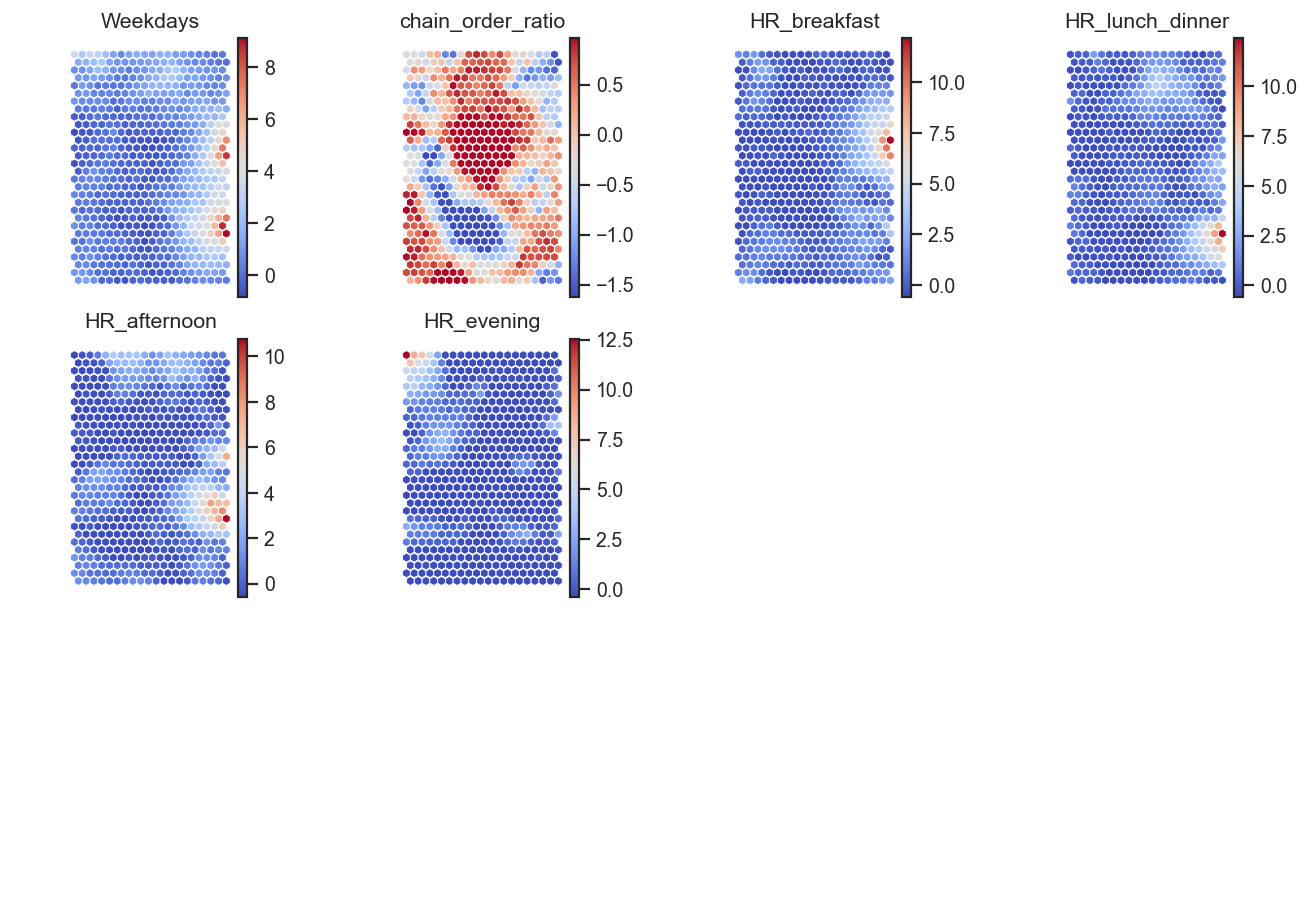

In [261]:
##############################
# Plot Component Planes
##############################

figsize=(10,7)
fig = plt.figure(figsize=figsize, constrained_layout=True, dpi=128, )

subfigs = fig.subfigures(3,4,wspace=.15)

colornorm = mpl_colors.Normalize(vmin=np.min(weights), vmax=np.max(weights))

for cpi, sf in zip(range(len(behaviour_features)), subfigs.flatten()):
    
    matrix_vals = weights[:,:,cpi]
    vext = np.max(np.abs([np.min(matrix_vals), np.max(matrix_vals)]))
    colornorm = mpl_colors.Normalize(vmin=np.min(matrix_vals), vmax=np.max(matrix_vals))
    # colornorm = mpl_colors.CenteredNorm(vcenter=0, halfrange=vext)


    sf = plot_hexagons(sm, sf, 
                    colornorm,
                    matrix_vals,
                    label=behaviour_features[cpi],
                    cmap=cm.coolwarm,
                    )

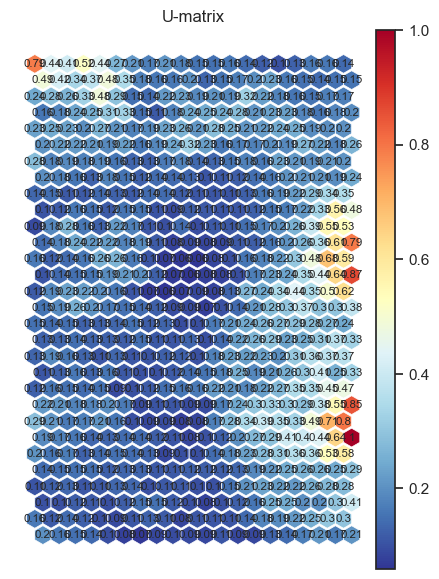

In [262]:
umatrix = sm.distance_map(scaling='mean')
fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=np.min(umatrix), vmax=np.max(umatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    umatrix,
                    label="U-matrix",
                    cmap=cm.RdYlBu_r,
                    annot=True
                    )

In [263]:
## Flip and rotate to match plot
print(np.flip(np.round(umatrix,2), axis=1).T)

[[0.79 0.44 0.41 0.52 0.44 0.27 0.21 0.17 0.21 0.18 0.15 0.15 0.16 0.14
  0.12 0.1  0.13 0.16 0.16 0.14]
 [0.49 0.42 0.34 0.37 0.48 0.35 0.18 0.16 0.16 0.2  0.13 0.15 0.17 0.2
  0.23 0.16 0.15 0.14 0.15 0.15]
 [0.24 0.28 0.26 0.33 0.48 0.29 0.15 0.14 0.22 0.23 0.19 0.21 0.19 0.32
  0.22 0.18 0.16 0.15 0.17 0.17]
 [0.16 0.18 0.24 0.25 0.31 0.33 0.15 0.11 0.18 0.24 0.25 0.24 0.28 0.21
  0.23 0.23 0.18 0.16 0.18 0.2 ]
 [0.23 0.25 0.23 0.2  0.27 0.21 0.17 0.19 0.23 0.26 0.21 0.28 0.25 0.21
  0.22 0.24 0.25 0.19 0.2  0.2 ]
 [0.2  0.22 0.22 0.21 0.19 0.22 0.16 0.19 0.24 0.32 0.23 0.16 0.17 0.17
  0.2  0.19 0.27 0.22 0.18 0.26]
 [0.28 0.18 0.19 0.18 0.19 0.16 0.13 0.13 0.17 0.18 0.14 0.13 0.15 0.18
  0.16 0.23 0.21 0.19 0.21 0.2 ]
 [0.2  0.18 0.16 0.13 0.18 0.15 0.12 0.14 0.14 0.13 0.1  0.11 0.12 0.14
  0.16 0.2  0.21 0.21 0.19 0.24]
 [0.14 0.15 0.11 0.12 0.14 0.13 0.12 0.14 0.14 0.12 0.11 0.11 0.11 0.13
  0.16 0.19 0.22 0.29 0.34 0.35]
 [0.1  0.12 0.16 0.15 0.12 0.15 0.15 0.11 0.09 0.12 0.11

In [264]:
sm.quantization_error(df_bhv.values)

0.3104825452140771

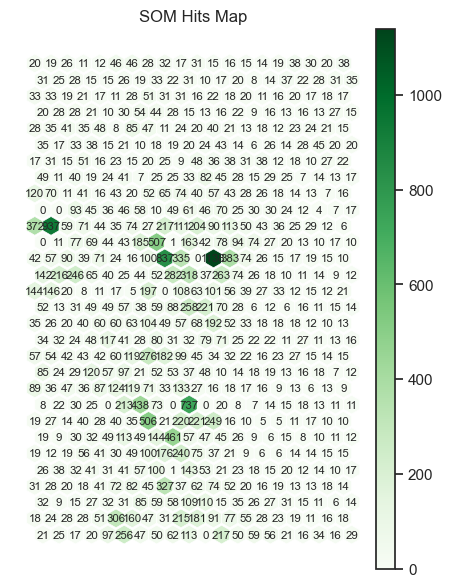

In [265]:
hitsmatrix = sm.activation_response(df_bhv.values)


fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hitsmatrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hitsmatrix,
                    label="SOM Hits Map",
                    cmap=cm.Greens,
                    annot=True
                    )

In [266]:
np.flip(np.round(hitsmatrix,2), axis=1).T

array([[2.000e+01, 1.900e+01, 2.600e+01, 1.100e+01, 1.200e+01, 4.600e+01,
        4.600e+01, 2.800e+01, 3.200e+01, 1.700e+01, 3.100e+01, 1.500e+01,
        1.600e+01, 1.500e+01, 1.400e+01, 1.900e+01, 3.800e+01, 3.000e+01,
        2.000e+01, 3.800e+01],
       [3.100e+01, 2.500e+01, 2.800e+01, 1.500e+01, 1.500e+01, 2.600e+01,
        1.900e+01, 3.300e+01, 2.200e+01, 3.100e+01, 1.000e+01, 1.700e+01,
        2.000e+01, 8.000e+00, 1.400e+01, 3.700e+01, 2.200e+01, 2.800e+01,
        3.100e+01, 3.500e+01],
       [3.300e+01, 3.300e+01, 1.900e+01, 2.100e+01, 1.700e+01, 1.100e+01,
        2.800e+01, 5.100e+01, 3.100e+01, 3.100e+01, 1.600e+01, 2.200e+01,
        1.800e+01, 2.000e+01, 1.100e+01, 1.600e+01, 2.000e+01, 1.700e+01,
        1.800e+01, 1.700e+01],
       [2.000e+01, 2.800e+01, 2.800e+01, 2.100e+01, 1.000e+01, 3.000e+01,
        5.400e+01, 4.400e+01, 2.800e+01, 1.500e+01, 1.300e+01, 1.600e+01,
        2.200e+01, 9.000e+00, 1.600e+01, 1.300e+01, 1.600e+01, 1.300e+01,
        2.700e+01, 

In [267]:
weights_flat = sm.get_weights().reshape((M*N),len(behaviour_features))
weights_flat.shape

(600, 6)

In [268]:
# Perform K-Means clustering on top of the MxN units (sm.get_node_vectors() output)
kmeans = KMeans(n_clusters=4, init='k-means++', n_init=15, random_state=15)
nodeclus_labels = kmeans.fit_predict(weights_flat)
nodeclus_labels

array([2, 2, 3, 3, 3, 3, 3, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 0, 0, 0, 0, 0, 0, 0, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 0,
       0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 3,
       3, 3, 3, 3, 0, 0, 0, 0, 0, 0, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 0, 3, 0, 2, 2, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 0, 0, 0, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 3, 2, 3, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 3, 2, 2, 3,

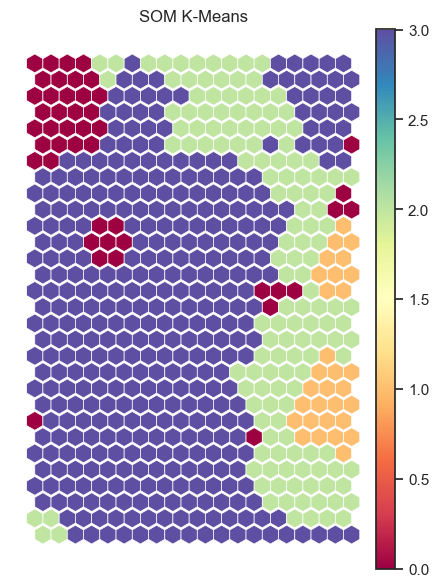

In [269]:
kmeans_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(kmeans_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    kmeans_matrix,
                    label="SOM K-Means",
                    cmap=cm.Spectral,
                    )

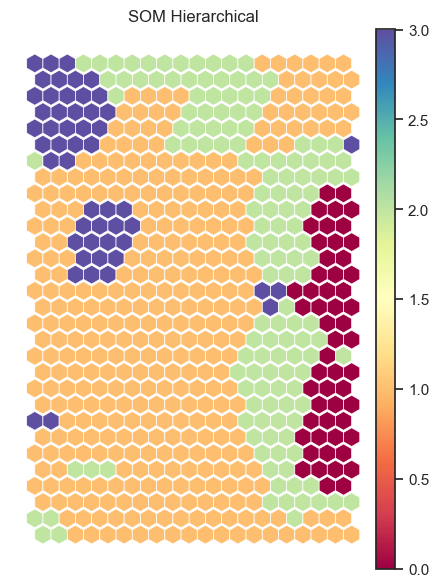

In [270]:
# Perform Hierarchical clustering on top of the MxN units 

hierclust = AgglomerativeClustering(n_clusters=4, linkage='ward')
nodeclus_labels = hierclust.fit_predict(weights_flat)
hclust_matrix = nodeclus_labels.reshape((M,N))

fig = plt.figure(figsize=figsize)

colornorm = mpl_colors.Normalize(vmin=0, vmax=np.max(hclust_matrix))

fig = plot_hexagons(sm, fig, 
                    colornorm,
                    hclust_matrix,
                    label="SOM Hierarchical",
                    cmap=cm.Spectral,
                    )

In [271]:
# Check the nodes and and respective clusters
nodes = weights_flat

df_nodes = pd.DataFrame(nodes, columns=behaviour_features)
df_nodes['behaviour_label'] = nodeclus_labels
df_nodes

Weekdays  chain_order_ratio  HR_breakfast  HR_lunch_dinner  HR_afternoon  \
0    1.059767           0.128968      2.397451        -0.392385      1.150606   
1    0.945578           0.748105      0.893318         0.710768      1.206218   
2    0.455680           0.825609      0.502449         0.359815      0.730990   
3    0.533056           0.934147      0.386849        -0.059727      1.296613   
4    0.407721           0.866103      0.192942        -0.131483      0.707562   
..        ...                ...           ...              ...           ...   
595  0.717222          -0.223745      1.106562         1.073153     -0.503840   
596  0.769304          -0.853582     -0.266651         1.721219     -0.528042   
597  0.593823          -1.466447     -0.300819         1.100125     -0.413485   
598 -0.000836          -1.568268     -0.442874         0.962382      0.008710   
599  0.147310          -1.577034     -0.467512         0.359034      0.528917   

     HR_evening  behaviour_label  
0     -0.387936                2  
1     -0.392038                2  
2     -0.392134                1  
3     -0.392006                1  
4     -0.345798                1  
..          ...              ...  
595    0.620675                1  
596    0.300353                1  
597    0.645385                1  
598   -0.364992                1  
599   -0.392124                1  

[600 rows x 7 columns]

In [272]:
## This gets BMU coordinates, e.g. (4,4) for each data point
bmu_index = np.array([sm.winner(x) for x in df_bhv.values])

print(bmu_index.shape)

bmu_index

(31717, 2)


array([[10,  1],
       [11, 18],
       [11, 18],
       ...,
       [ 7, 18],
       [ 9,  5],
       [ 9,  7]], dtype=int64)

In [273]:

## This gets the cluster label from hclust_matrix, i.e.
## if data row 0 has BMU at (37, 28) 
## it will get the label associated to node (37,28) using label associated to hclust_matrix[37,28] above

som_final_labels = [hclust_matrix[i[0]][i[1]] for i in bmu_index]

In [274]:
df = pd.concat([
                df,
                pd.Series(som_final_labels, name='behaviour_label', index=df.index)
            ], axis=1
            )

df

customer_region  customer_age  vendor_count  product_count  is_chain  \
0                 2360     -1.337468     -0.405436      -0.098281 -0.475544   
1                 8670     -1.478630     -0.405436      -0.555346 -0.212185   
2                 4660      1.485773     -0.771607      -0.555346 -0.212185   
3                 4660     -0.208171     -0.405436      -0.402991 -0.475544   
4                 4660     -1.055144     -0.405436      -0.098281 -0.738902   
...                ...           ...           ...            ...       ...   
31712             8670      0.356477     -0.771607      -0.707701 -0.475544   
31713             8670     -0.208171     -0.771607      -0.707701 -0.738902   
31714             8670     -0.490496     -0.771607      -0.707701 -0.475544   
31715             8670      0.921125     -0.771607      -0.707701 -0.738902   
31716             4660      0.356477     -0.771607      -0.707701 -0.738902   

       first_order  last_order last_promo payment_method  CUI_American  ...  \
0        -1.175717   -2.706721   DELIVERY           DIGI     -0.422050  ...   
1        -1.175717   -2.706721   DISCOUNT           DIGI      0.686724  ...   
2        -1.175717   -2.706721   DISCOUNT           CASH      0.373638  ...   
3        -1.175717   -2.663582   DELIVERY           DIGI     -0.422050  ...   
4        -1.175717   -2.663582          -           DIGI      0.838078  ...   
...            ...         ...        ...            ...           ...  ...   
31712    -1.175717   -2.749860    FREEBIE           DIGI     -0.422050  ...   
31713    -1.175717   -2.749860   DELIVERY           DIGI      1.138191  ...   
31714    -1.175717   -2.749860          -           DIGI     -0.422050  ...   
31715    -1.175717   -2.749860   DISCOUNT           DIGI     -0.422050  ...   
31716    -1.175717   -2.749860          -           CASH     -0.422050  ...   

        Weekend  total_spent  total_orders  avg_spending_per_order  \
0      0.429816    -0.209739      -0.48370                0.528655   
1      0.429816    -0.427887      -0.48370               -0.088755   
2      0.429816    -0.653705      -0.48370               -0.727873   
3     -0.148714    -0.149281      -0.48370                0.699767   
4     -0.148714     0.389434      -0.48370                2.224456   
...         ...          ...           ...                     ...   
31712 -0.148714    -0.454282      -0.68905                0.988360   
31713 -0.148714    -0.454282      -0.68905                0.988360   
31714 -0.148714    -0.459921      -0.68905                0.956436   
31715 -0.148714    -0.589863      -0.68905                0.220908   
31716 -0.148714    -0.682807      -0.68905               -0.305200   

       chain_order_ratio  preferred_cui     preferred_cui_type  value_label  \
0              -0.327866     CUI_Indian          Asian_Cuisine            2   
1               0.963778   CUI_American        Western_Cuisine            2   
2               0.963778   CUI_American        Western_Cuisine            2   
3              -0.327866     CUI_Indian          Asian_Cuisine            2   
4              -1.619510      CUI_Asian          Asian_Cuisine            2   
...                  ...            ...                    ...          ...   
31712           0.963778  CUI_Beverages  Complementary_Cuisine            2   
31713          -1.619510   CUI_American        Western_Cuisine            2   
31714           0.963778   CUI_Desserts  Complementary_Cuisine            2   
31715          -1.619510      CUI_Asian          Asian_Cuisine            2   
31716          -1.619510    CUI_Italian        Western_Cuisine            2   

       prf_label  behaviour_label  
0              1                1  
1              1                1  
2              1                1  
3              1                1  
4              1                1  
...          ...              ...  
31712          1                1  
31713          1               

In [275]:
# Characterizing the final clusters
df_centroids = df[behaviour_features + ['behaviour_label']].groupby('behaviour_label').mean()

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)
df_styled

In [276]:
df["behaviour_label"].value_counts()

behaviour_label
1    26333
2     2743
3     1957
0      684
Name: count, dtype: int64

In [277]:
# Calculate R2 and see the score
def get_sst(df): 
    """
    Calculates the sum of squared distances of each point to the mean of the points
    """
    return np.sum(df.var() * (df.count() - 1))

def get_r2_score(df, labels):
    """
    Calculates the proportion of variance explained by the clustering (r2)
    """
    sst = get_sst(df)
    ssw = np.sum(df.groupby(labels).apply(get_sst))
    ssb = sst - ssw
    return ssb / sst

In [278]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df[behaviour_features])  # get total sum of squares
ssw_labels = df[behaviour_features + ["behaviour_label"]].groupby(by='behaviour_label').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.3746074085729897

In [279]:
calinski_harabasz = calinski_harabasz_score(df_bhv, som_final_labels)
print('Calinski Harabasz Score: ', round(calinski_harabasz,3))

Calinski Harabasz Score:  6331.982


In [280]:
# This is step can be quite time consuming
#two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df[behaviour_features])

# t-SNE visualization
#pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df['behaviour_label'], colormap='tab10', figsize=(15,10))
#plt.show()

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 4. Merging perspetives
    

    
</div>

In [281]:
# Centroids of the concatenated cluster labels
df_centroids = df.groupby(['value_label', 'prf_label', 'behaviour_label'])\
    [metric_features].mean()
df_centroids

total_spent  avg_spending_per_order  \
value_label prf_label behaviour_label                                        
0           0         0                   4.705035               -0.049956   
                      1                   2.998026                1.171429   
                      2                   3.688207                0.564536   
                      3                   4.211785                0.797554   
            1         0                   2.427232               -0.529128   
                      1                   2.073834                0.812054   
                      2                   2.201689               -0.005978   
                      3                   2.372620                0.490767   
            2         0                   3.850978               -0.252075   
                      1                   2.067523                0.441957   
                      2                   2.653488                0.035911   
                      3                   2.933830                0.402668   
            3         0                   5.033444               -0.205385   
                      1                   2.119638                0.575347   
                      2                   3.189250                0.186496   
                      3                   4.143793                0.528117   
1           0         1                   2.144694                1.369775   
                      2                   2.039982                0.162504   
                      3                   1.952294                0.376051   
            1         0                   0.957838               -0.825173   
                      1                  -0.229483               -0.143612   
                      2                   0.476978               -0.555241   
                      3                   0.508698                0.140406   
            2         0                   1.319204               -0.679475   
                      1                   0.340767                0.075606   
                      2                   0.938029               -0.363669   
                      3                   0.793885                0.326176   
            3         0                   1.201768               -0.624729   
                      1                   1.041171                0.744630   
                      2                   1.160951               -0.074525   
                      3                   1.005592                0.378494   
2           1         0                   0.237610               -0.926520   
                      1                  -0.447394               -0.065851   
                      2                   0.036118               -0.668758   
                      3                  -0.049078                0.110247   
            2         1                  -0.004146                0.417045   
                      2                   0.091173               -0.382381   
                      3                   0.144646                0.153206   
            3         3                   0.591189                0.470659   
3           0         1                   2.827014                2.975894   
                      2                   2.911911                1.315327   
                      3                   3.017001                1.773677   
            1         1                   0.726041                3.467778   
                      2                   2.620781                1.341581   
                      3                   1.842226                1.860550   
            2         1                   0.614556                3.084486   
                      2                   2.765713                1.242205   
                      3                   2.559623                1.947438   
            3         0                   3.377181                0.684018   
                      1                   1.627408           

In [282]:
# Using Hierarchical clustering to merge the concatenated cluster centroids
linkage = 'ward'
hclust = AgglomerativeClustering(
    linkage=linkage, 
    metric='euclidean', 
    distance_threshold=0, 
    n_clusters=None
)

hclust_labels = hclust.fit_predict(df_centroids)

In [283]:
#hierarchical_clustering_methods_nclust_analysis(df[metric_features], ["ward"], 7)

In [284]:
# Re-running the Hierarchical clustering based on the correct number of clusters
hclust = AgglomerativeClustering(
    linkage='ward', 
    metric='euclidean', 
    n_clusters=6
)
hclust_labels = hclust.fit_predict(df_centroids)
df_centroids['hclust_labels'] = hclust_labels

df_centroids  # centroid's cluster labels

total_spent  avg_spending_per_order  \
value_label prf_label behaviour_label                                        
0           0         0                   4.705035               -0.049956   
                      1                   2.998026                1.171429   
                      2                   3.688207                0.564536   
                      3                   4.211785                0.797554   
            1         0                   2.427232               -0.529128   
                      1                   2.073834                0.812054   
                      2                   2.201689               -0.005978   
                      3                   2.372620                0.490767   
            2         0                   3.850978               -0.252075   
                      1                   2.067523                0.441957   
                      2                   2.653488                0.035911   
                      3                   2.933830                0.402668   
            3         0                   5.033444               -0.205385   
                      1                   2.119638                0.575347   
                      2                   3.189250                0.186496   
                      3                   4.143793                0.528117   
1           0         1                   2.144694                1.369775   
                      2                   2.039982                0.162504   
                      3                   1.952294                0.376051   
            1         0                   0.957838               -0.825173   
                      1                  -0.229483               -0.143612   
                      2                   0.476978               -0.555241   
                      3                   0.508698                0.140406   
            2         0                   1.319204               -0.679475   
                      1                   0.340767                0.075606   
                      2                   0.938029               -0.363669   
                      3                   0.793885                0.326176   
            3         0                   1.201768               -0.624729   
                      1                   1.041171                0.744630   
                      2                   1.160951               -0.074525   
                      3                   1.005592                0.378494   
2           1         0                   0.237610               -0.926520   
                      1                  -0.447394               -0.065851   
                      2                   0.036118               -0.668758   
                      3                  -0.049078                0.110247   
            2         1                  -0.004146                0.417045   
                      2                   0.091173               -0.382381   
                      3                   0.144646                0.153206   
            3         3                   0.591189                0.470659   
3           0         1                   2.827014                2.975894   
                      2                   2.911911                1.315327   
                      3                   3.017001                1.773677   
            1         1                   0.726041                3.467778   
                      2                   2.620781                1.341581   
                      3                   1.842226                1.860550   
            2         1                   0.614556                3.084486   
                      2                   2.765713                1.242205   
                      3                   2.559623                1.947438   
            3         0                   3.377181                0.684018   
                      1                   1.627408           

In [285]:
# Mapper between concatenated clusters and hierarchical clusters
cluster_mapper = df_centroids['hclust_labels'].to_dict()
cluster_mapper

{(0, 0, 0): 4,
 (0, 0, 1): 5,
 (0, 0, 2): 5,
 (0, 0, 3): 2,
 (0, 1, 0): 0,
 (0, 1, 1): 5,
 (0, 1, 2): 5,
 (0, 1, 3): 2,
 (0, 2, 0): 0,
 (0, 2, 1): 0,
 (0, 2, 2): 0,
 (0, 2, 3): 2,
 (0, 3, 0): 4,
 (0, 3, 1): 1,
 (0, 3, 2): 1,
 (0, 3, 3): 1,
 (1, 0, 1): 5,
 (1, 0, 2): 5,
 (1, 0, 3): 2,
 (1, 1, 0): 0,
 (1, 1, 1): 3,
 (1, 1, 2): 3,
 (1, 1, 3): 3,
 (1, 2, 0): 0,
 (1, 2, 1): 3,
 (1, 2, 2): 0,
 (1, 2, 3): 3,
 (1, 3, 0): 1,
 (1, 3, 1): 1,
 (1, 3, 2): 1,
 (1, 3, 3): 1,
 (2, 1, 0): 0,
 (2, 1, 1): 3,
 (2, 1, 2): 3,
 (2, 1, 3): 3,
 (2, 2, 1): 3,
 (2, 2, 2): 3,
 (2, 2, 3): 3,
 (2, 3, 3): 1,
 (3, 0, 1): 5,
 (3, 0, 2): 5,
 (3, 0, 3): 2,
 (3, 1, 1): 3,
 (3, 1, 2): 5,
 (3, 1, 3): 2,
 (3, 2, 1): 3,
 (3, 2, 2): 0,
 (3, 2, 3): 2,
 (3, 3, 0): 1,
 (3, 3, 1): 1,
 (3, 3, 2): 1,
 (3, 3, 3): 1}

In [286]:
df_hc = df.copy()

# Mapping the hierarchical clusters on the centroids to the observations
df_hc['merged_labels'] = df_hc.apply(
    lambda row: cluster_mapper[
        (row['value_label'], row['prf_label'], row['behaviour_label'])
    ], axis=1
)

df_hc

customer_region  customer_age  vendor_count  product_count  is_chain  \
0                 2360     -1.337468     -0.405436      -0.098281 -0.475544   
1                 8670     -1.478630     -0.405436      -0.555346 -0.212185   
2                 4660      1.485773     -0.771607      -0.555346 -0.212185   
3                 4660     -0.208171     -0.405436      -0.402991 -0.475544   
4                 4660     -1.055144     -0.405436      -0.098281 -0.738902   
...                ...           ...           ...            ...       ...   
31712             8670      0.356477     -0.771607      -0.707701 -0.475544   
31713             8670     -0.208171     -0.771607      -0.707701 -0.738902   
31714             8670     -0.490496     -0.771607      -0.707701 -0.475544   
31715             8670      0.921125     -0.771607      -0.707701 -0.738902   
31716             4660      0.356477     -0.771607      -0.707701 -0.738902   

       first_order  last_order last_promo payment_method  CUI_American  ...  \
0        -1.175717   -2.706721   DELIVERY           DIGI     -0.422050  ...   
1        -1.175717   -2.706721   DISCOUNT           DIGI      0.686724  ...   
2        -1.175717   -2.706721   DISCOUNT           CASH      0.373638  ...   
3        -1.175717   -2.663582   DELIVERY           DIGI     -0.422050  ...   
4        -1.175717   -2.663582          -           DIGI      0.838078  ...   
...            ...         ...        ...            ...           ...  ...   
31712    -1.175717   -2.749860    FREEBIE           DIGI     -0.422050  ...   
31713    -1.175717   -2.749860   DELIVERY           DIGI      1.138191  ...   
31714    -1.175717   -2.749860          -           DIGI     -0.422050  ...   
31715    -1.175717   -2.749860   DISCOUNT           DIGI     -0.422050  ...   
31716    -1.175717   -2.749860          -           CASH     -0.422050  ...   

       total_spent  total_orders  avg_spending_per_order  chain_order_ratio  \
0        -0.209739      -0.48370                0.528655          -0.327866   
1        -0.427887      -0.48370               -0.088755           0.963778   
2        -0.653705      -0.48370               -0.727873           0.963778   
3        -0.149281      -0.48370                0.699767          -0.327866   
4         0.389434      -0.48370                2.224456          -1.619510   
...            ...           ...                     ...                ...   
31712    -0.454282      -0.68905                0.988360           0.963778   
31713    -0.454282      -0.68905                0.988360          -1.619510   
31714    -0.459921      -0.68905                0.956436           0.963778   
31715    -0.589863      -0.68905                0.220908          -1.619510   
31716    -0.682807      -0.68905               -0.305200          -1.619510   

       preferred_cui     preferred_cui_type  value_label  prf_label  \
0         CUI_Indian          Asian_Cuisine            2          1   
1       CUI_American        Western_Cuisine            2          1   
2       CUI_American        Western_Cuisine            2          1   
3         CUI_Indian          Asian_Cuisine            2          1   
4          CUI_Asian          Asian_Cuisine            2          1   
...              ...                    ...          ...        ...   
31712  CUI_Beverages  Complementary_Cuisine            2          1   
31713   CUI_American        Western_Cuisine            2          1   
31714   CUI_Desserts  Complementary_Cuisine            2          1   
31715      CUI_Asian          Asian_Cuisine            2          1   
31716    CUI_Italian        Western_Cuisine            2          1   

       behaviour_label  merged_labels  
0                    1              3  
1                    1              3  
2                    1              3  
3                    1              3  
4                    1              3  
...                ...            ...  
31712                1     

In [287]:
df_hc['merged_labels'].value_counts()

merged_labels
3    29420
0      925
5      476
2      455
4      225
1      216
Name: count, dtype: int64

<a class="anchor" id="3rd-bullet">

### Unscaled Groups Mean:
</a>

In [288]:
# To revert back to original values
original_values = ss_scaler.inverse_transform(df_hc[columns_to_scale])

# Update the df with the original values
df_hc[columns_to_scale] = original_values

# Calculate the mean of each group
df_centroids = df_hc[metric_features + ['merged_labels']].groupby('merged_labels').mean(numeric_only=True)

# Apply gradient styling to the DataFrame
df_styled = df_centroids.style.background_gradient(cmap='Blues', axis=0)

# Display the styled DataFrame
df_styled

<div class="alert alert-block alert-success">

<a class="anchor" id="1st-bullet">    </a>
## 5. Cluster profiling -  Association with categorical features

    
</div>

<a class="anchor" id="3rd-bullet">

### Cluster Analysis General
</a>

In [299]:
def cluster_profiles(df, label_columns, figsize, 
                     cmap="tab10",
                     compare_titles=None):
    """
    Pass df with labels columns of one or multiple clustering labels. 
    Then specify this label columns to perform the cluster profile according to them.
    """
    
    if compare_titles == None:
        compare_titles = [""]*len(label_columns)
        
    fig, axes = plt.subplots(nrows=len(label_columns), 
                             ncols=2, 
                             figsize=figsize, 
                             constrained_layout=True,
                             squeeze=False)
    for ax, label, titl in zip(axes, label_columns, compare_titles):
        # Filtering df
        drop_cols = [i for i in label_columns if i!=label]
        dfax = df.drop(drop_cols, axis=1)
        
        # Getting the cluster centroids and counts
        centroids = dfax.groupby(by=label, as_index=False).mean()
        counts = dfax.groupby(by=label, as_index=False).count().iloc[:,[0,1]]
        counts.columns = [label, "counts"]
        
        # Setting Data
        pd.plotting.parallel_coordinates(centroids, 
                                            label, 
                                            color = sns.color_palette(cmap),
                                            ax=ax[0])



        sns.barplot(x=label, 
                    hue=label,
                    y="counts", 
                    data=counts, 
                    ax=ax[1], 
                    palette=sns.color_palette(cmap),
                    legend=False
                    )

        #Setting Layout
        handles, _ = ax[0].get_legend_handles_labels()
        cluster_labels = ["Cluster {}".format(i) for i in range(len(handles))]
        ax[0].annotate(text=titl, xy=(0.95,1.1), xycoords='axes fraction', fontsize=13, fontweight = 'heavy') 
        ax[0].axhline(color="black", linestyle="--")
        ax[0].set_title("Cluster Means - {} Clusters".format(len(handles)), fontsize=13)
        ax[0].set_xticklabels(ax[0].get_xticklabels(), 
                              rotation=40,
                              ha='right'
                              )
        
        ax[0].legend(handles, cluster_labels,
                     loc='center left', bbox_to_anchor=(1, 0.5), title=label
                     ) # Adaptable to number of clusters
        
        ax[1].set_xticks([i for i in range(len(handles))])
        ax[1].set_xticklabels(cluster_labels)
        ax[1].set_xlabel("")
        ax[1].set_ylabel("Absolute Frequency")
        ax[1].set_title("Cluster Sizes - {} Clusters".format(len(handles)), fontsize=13)
        
        
    
    # plt.subplots_adjust(hspace=0.4, top=0.90)
    plt.suptitle("Cluster Simple Profiling", fontsize=23)
    plt.show()

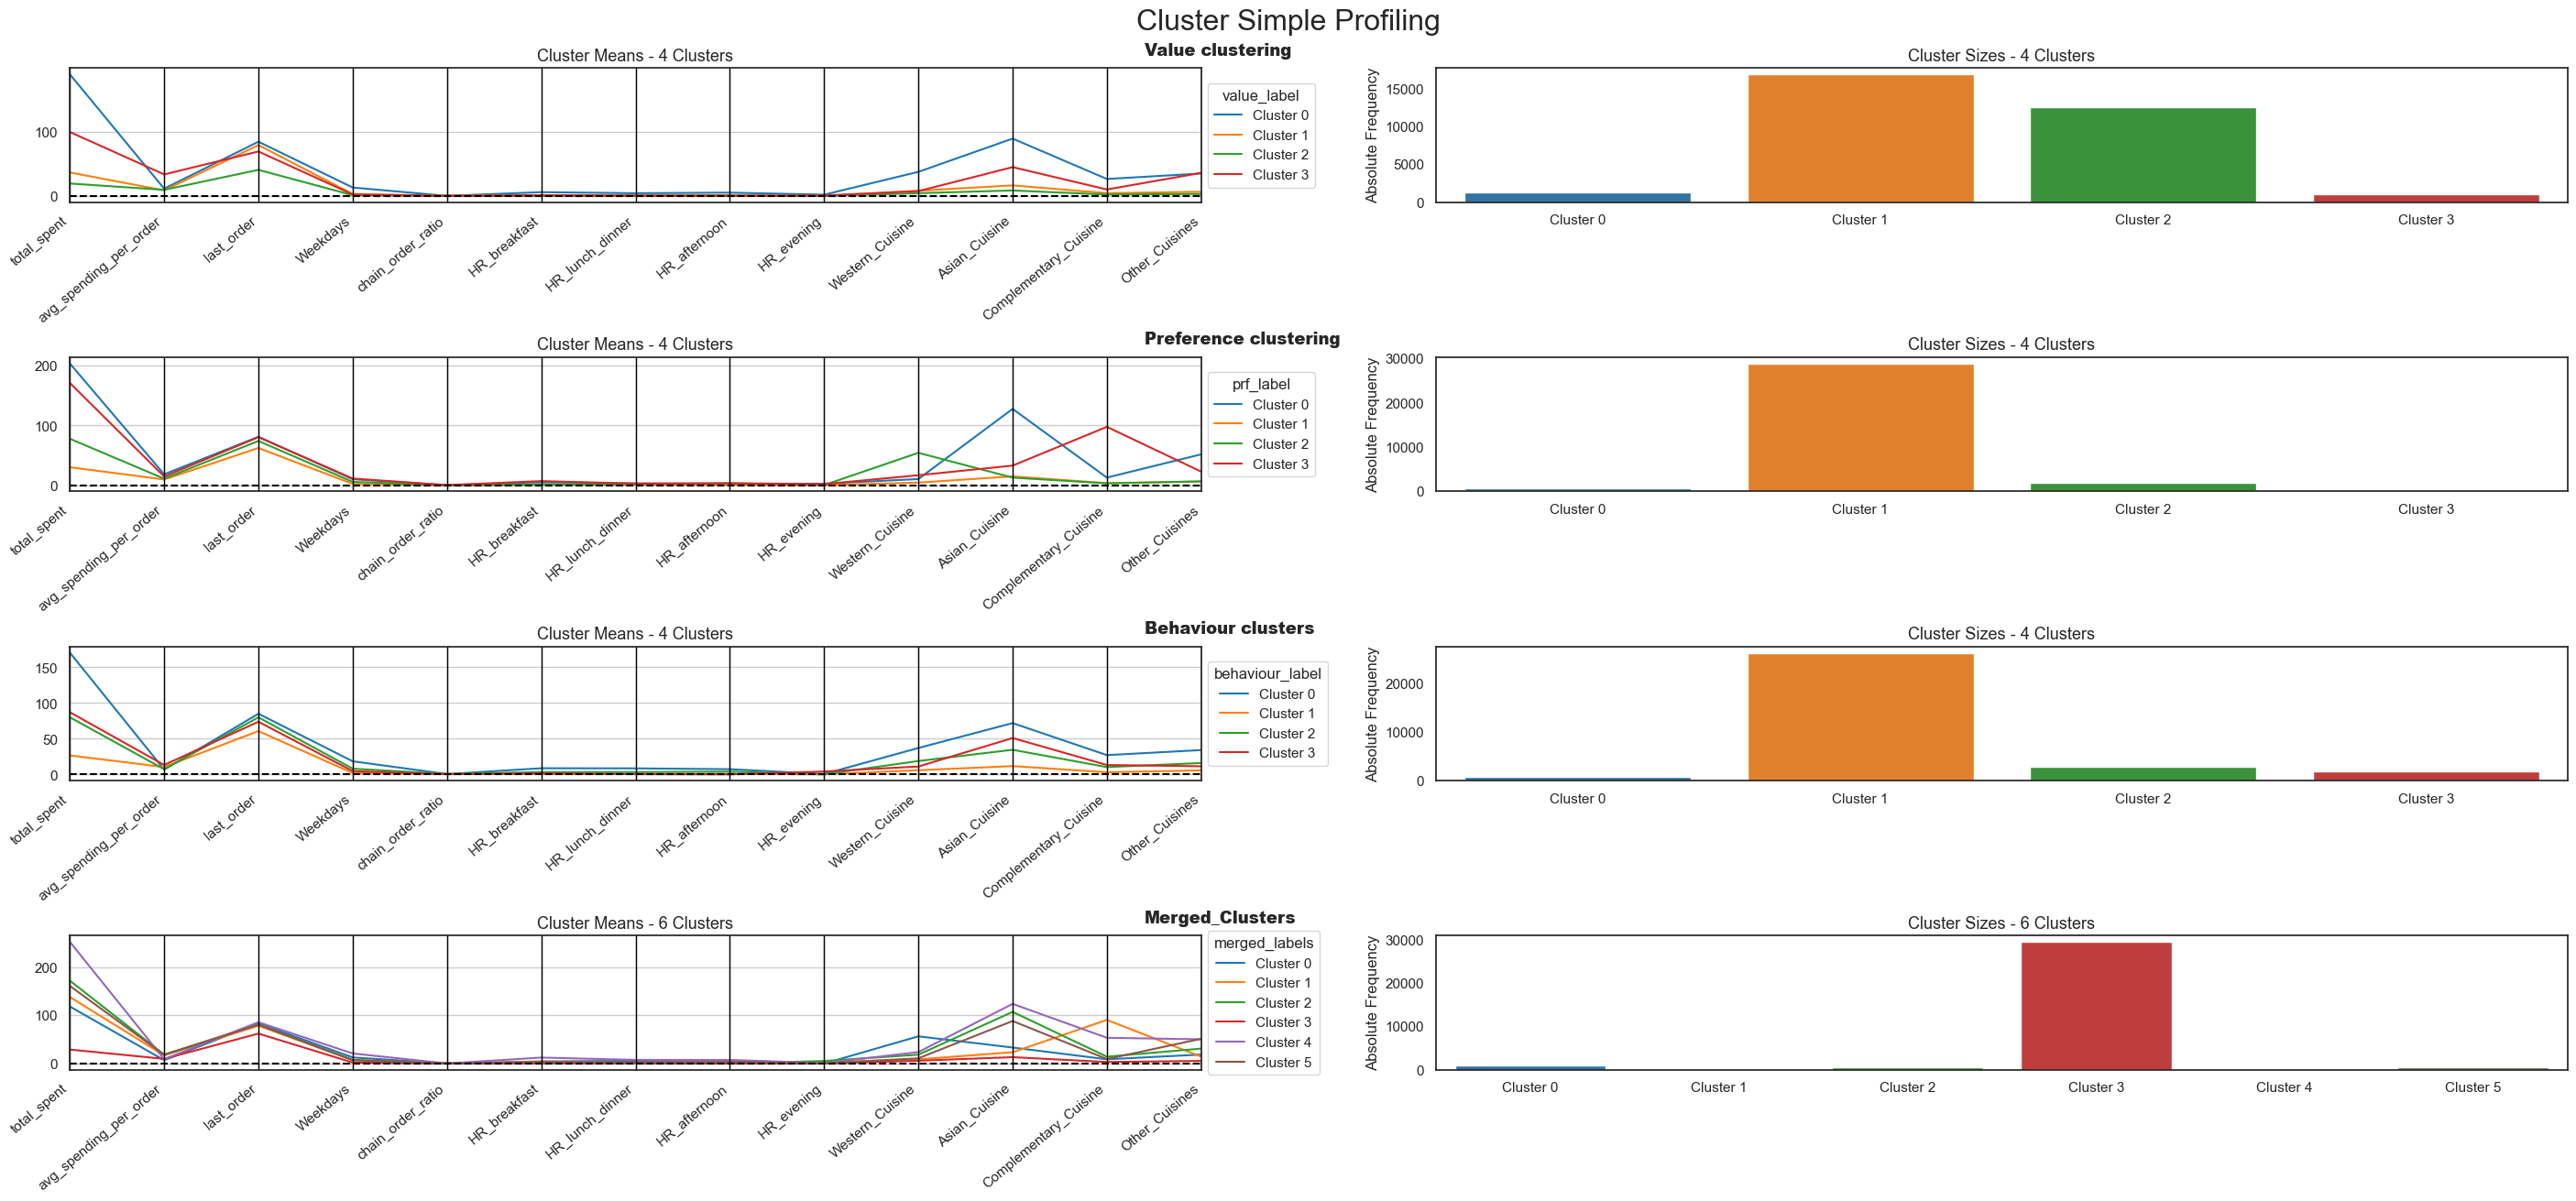

In [300]:
# Profilling each cluster (product, behavior, merged)
cluster_profiles(
    df = df_hc[metric_features + ['value_label', 'prf_label', 'behaviour_label', 'merged_labels']], 
    label_columns = ['value_label', 'prf_label', 'behaviour_label', 'merged_labels'], 
    figsize = (28, 13), 
    compare_titles = ["Value clustering", "Preference clustering", "Behaviour clusters", "Merged_Clusters"]
)

<a class="anchor" id="3rd-bullet">

### Cluster profiling -  Association with categorical features
</a>

**Customer Region**

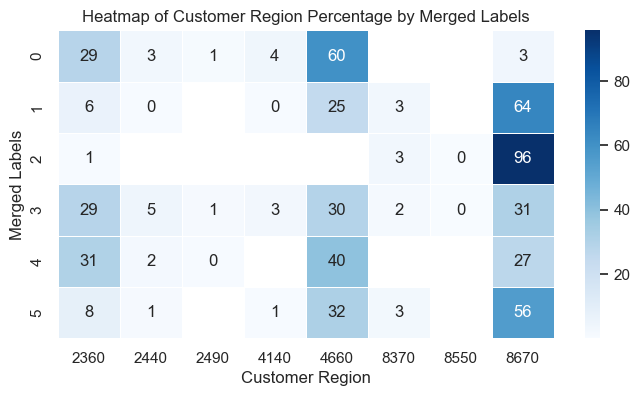

In [289]:
# Group by merged_labels and customer_region
df_cl_region = df_hc.groupby(['merged_labels', 'customer_region'])['customer_region'].size().unstack()

# Calculate the percentage distribution
df_cl_region_pct = df_cl_region.copy()
for i in df_hc['customer_region'].unique():
    df_cl_region_pct[i] = 100 * df_cl_region_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
sns.heatmap(df_cl_region_pct, annot=True, fmt='.0f', cmap='Blues', linewidths=.5)
plt.title('Heatmap of Customer Region Percentage by Merged Labels')
plt.xlabel('Customer Region')
plt.ylabel('Merged Labels')
plt.show()

**Age Category**

<Figure size 1000x600 with 0 Axes>

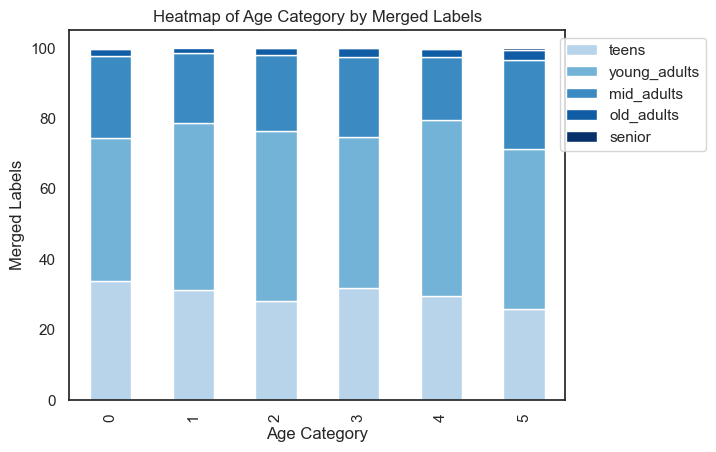

In [290]:
# Group by merged_labels and age_category
# Define the order of age categories from youngest to oldest
age_order = ['teens', 'young_adults', 'mid_adults', 'old_adults', 'senior']
df_hc['age_category'] = pd.Categorical(df_hc['age_category'], categories=age_order, ordered=True)

df_cl_age = df_hc.groupby(['merged_labels', 'age_category'])['age_category'].size().unstack()

# Reorder the columns based on the defined age order
df_cl_age = df_cl_age[age_order]

# Calculate the percentage distribution
df_cl_age_pct = df_cl_age.copy()
for i in df_hc['age_category'].unique():
    df_cl_age_pct[i] = 100 * df_cl_age_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(10, 6))
df_cl_age_pct.plot.bar(stacked=True, colormap=truncated_blues)
plt.title('Heatmap of Age Category by Merged Labels')
plt.xlabel('Age Category')
plt.ylabel('Merged Labels')
plt.legend(loc='upper right', bbox_to_anchor=(1.30, 1))
plt.show()

**Payment Method**

<Figure size 800x400 with 0 Axes>

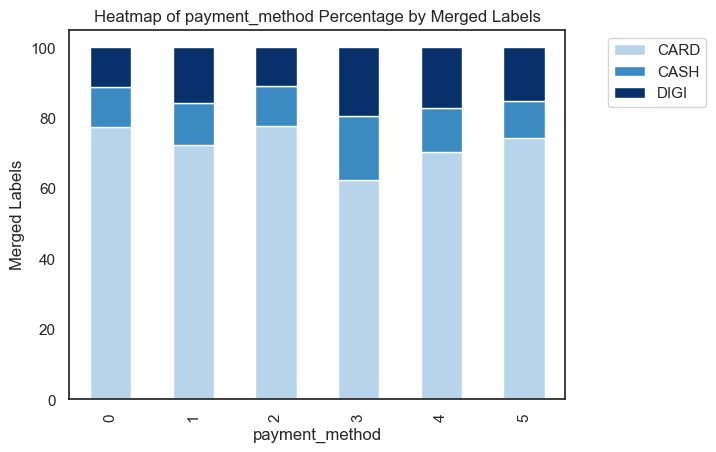

In [291]:
# Group by merged_labels and payment_method
df_cl_payment = df_hc.groupby(['merged_labels', 'payment_method'])['payment_method'].size().unstack()

# Calculate the percentage distribution
df_cl_payment_pct = df_cl_payment.copy()
for i in df_hc['payment_method'].unique():
    df_cl_payment_pct[i] = 100 * df_cl_payment_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
df_cl_payment_pct.plot.bar(stacked=True, colormap=truncated_blues)
plt.title('Heatmap of payment_method Percentage by Merged Labels')
plt.xlabel('payment_method')
plt.ylabel('Merged Labels')
plt.legend(loc='upper right', bbox_to_anchor=(1.30, 1))
plt.show()

**Last Promo**

<Figure size 800x400 with 0 Axes>

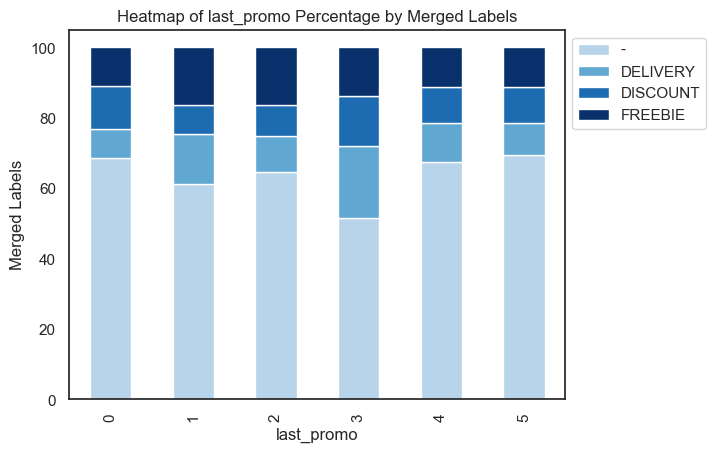

In [292]:
# Group by merged_labels and payment_method
df_cl_promo = df_hc.groupby(['merged_labels', 'last_promo'])['last_promo'].size().unstack()

# Calculate the percentage distribution
df_cl_promo_pct = df_cl_promo.copy()
for i in df_hc['last_promo'].unique():
    df_cl_promo_pct[i] = 100 * df_cl_promo_pct[i] / df_hc['merged_labels'].value_counts().sort_index().values

# Plot heatmap
plt.figure(figsize=(8, 4))
df_cl_promo_pct.plot.bar(stacked=True, colormap=truncated_blues)
plt.title('Heatmap of last_promo Percentage by Merged Labels')
plt.xlabel('last_promo')
plt.ylabel('Merged Labels')
plt.legend(loc='upper right', bbox_to_anchor=(1.30, 1))
plt.show()

In [293]:
# using R²
def get_ss(df):
    ss = np.sum(df.var() * (df.count() - 1))
    return ss  # return sum of sum of squares of each df variable

sst = get_ss(df_hc[metric_features])  # get total sum of squares
ssw_labels = df_hc[metric_features + ["merged_labels"]].groupby(by='merged_labels').apply(get_ss)  # compute ssw for each cluster labels
ssb = sst - np.sum(ssw_labels)  # remember: SST = SSW + SSB
r2 = ssb / sst
r2

0.40059733658937885

In [294]:
def get_ss_variables(df):
    """Get the SS for each variable
    """
    ss_vars = df.var() * (df.count() - 1)
    return ss_vars

def r2_variables(df, labels):
    """Get the R² for each variable
    """
    sst_vars = get_ss_variables(df)
    ssw_vars = np.sum(df.groupby(labels).apply(get_ss_variables))
    return 1 - ssw_vars/sst_vars

In [295]:
# We are essentially decomposing the R² into the R² for each variable
r2_variables(df_hc[metric_features + ['merged_labels']], 'merged_labels').drop('merged_labels')

total_spent               0.576828
avg_spending_per_order    0.044046
last_order                0.050030
Weekdays                  0.480426
chain_order_ratio         0.004869
HR_breakfast              0.345733
HR_lunch_dinner           0.204066
HR_afternoon              0.256119
HR_evening                0.257451
Western_Cuisine           0.266180
Asian_Cuisine             0.372226
Complementary_Cuisine     0.392113
Other_Cuisines            0.175643
dtype: float64

In [296]:
# Preparing the data
X = df_hc[metric_features]
y = df_hc.merged_labels

# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Fitting the decision tree
dt = DecisionTreeClassifier(random_state=42, max_depth=5)
dt.fit(X_train, y_train)
print("It is estimated that in average, we are able to predict {0:.2f}% of the customers correctly".format(dt.score(X_test, y_test)*100))

It is estimated that in average, we are able to predict 97.27% of the customers correctly


In [297]:
pd.Series(dt.feature_importances_, index=X_train.columns).to_frame(name='Importance')

Importance
total_spent               0.525916
avg_spending_per_order    0.000959
last_order                0.000000
Weekdays                  0.141240
chain_order_ratio         0.000000
HR_breakfast              0.027674
HR_lunch_dinner           0.027034
HR_afternoon              0.000000
HR_evening                0.074952
Western_Cuisine           0.093290
Asian_Cuisine             0.006992
Complementary_Cuisine     0.099769
Other_Cuisines            0.002174

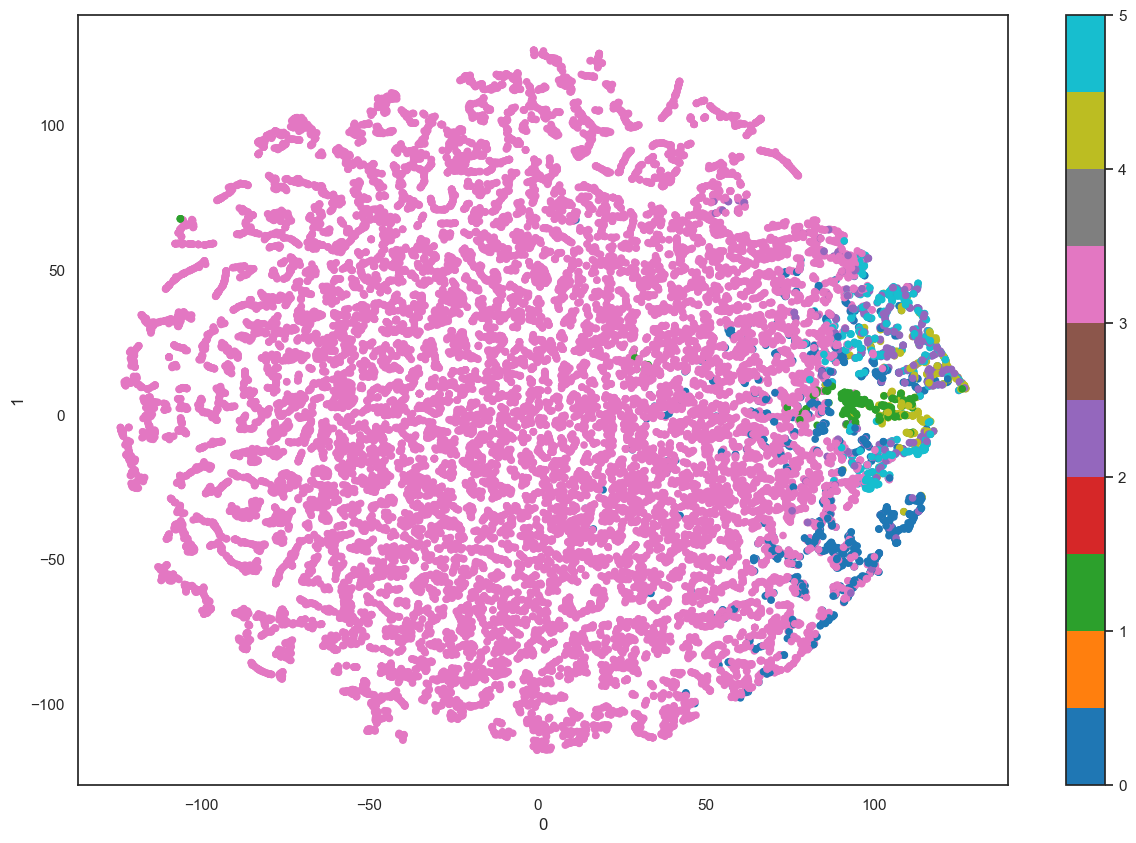

In [298]:
# This is step can be quite time consuming
two_dim = TSNE(random_state=42, perplexity=12).fit_transform(df_hc[metric_features])

# t-SNE visualization
pd.DataFrame(two_dim).plot.scatter(x=0, y=1, c=df_hc['merged_labels'], colormap='tab10', figsize=(15,10))
plt.show()